## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [ ]:
# installing the sentence-transformers for word embeddings
!pip install -U sentence-transformers transformers gensim tqdm -q

In [2]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

# for manipulating string data
import string

# library for regular expression
import re

# natural language toolkit and library for stemming
import nltk
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer

# library for word cloud and stopwords
from wordcloud import WordCloud, STOPWORDS

# Word2Vec
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Sentence Transformer
from sentence_transformers import SentenceTransformer

# pytorch
import torch

# library for data split and model evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer

# preprocessing
from sklearn.preprocessing import StandardScaler

# class weight and stratification
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

# lib for classifiers
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...


## **Loading the dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
stock_news = pd.read_csv('/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/stock_news.csv')
data = stock_news.copy()

## **Data Overview**

In [ ]:
# display max width of the column
pd.set_option('display.max_colwidth', None)
# display first 5 rows
data.head(5)

Date  \
0  2019-01-02   
1  2019-01-02   
2  2019-01-02   
3  2019-01-02   
4  2019-01-02   

                                                                                                                                                                                                                                                                                                                                   News  \
0   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.   
1    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10   
2                               Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon   
3                           This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple   
4                      Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets   

        Open       High        Low      Close     Volume  Label  
0  41.740002  42.244999  41.482498  40.246914  130672400     -1  
1  41.740002  42.244999  41.482498  40.246914  130672400     -1  
2  41.740002  42.244999  41.482498  40.246914  130672400     -1  
3  41.740002  42.244999  41.482498  40.246914  130672400     -1  
4  41.740002  42.244999  41.482498  40.246914  130672400     -1

In [ ]:
# checking the shape of the dataframe
data.shape

(349, 8)

In [ ]:
# structural information about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [ ]:
# checking null values
data.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

In [ ]:
# checking for duplicate values
data.duplicated().sum()

0

In [ ]:
# Statistical summary of data
data.describe(include='all').T

count unique  \
Date      349     71   
News      349    349   
Open    349.0    NaN   
High    349.0    NaN   
Low     349.0    NaN   
Close   349.0    NaN   
Volume  349.0    NaN   
Label   349.0    NaN   

                                                                                                                                                                                                                                                                                                                               top  \
Date                                                                                                                                                                                                                                                                                                                    2019-01-03   
News     In the first quarter, South Korea's Samsung Electronics reported its weakest profit in over two years due to falls in chip prices and slowing demand for display panels. The tech giant expects improved results in the second half of 2019, driven by a pickup in memory chip and smartphone sales. However, memory chip   
Open                                                                                                                                                                                                                                                                                                                           NaN   
High                                                                                                                                                                                                                                                                                                                           NaN   
Low                                                                                                                                                                                                                                                                                                                            NaN   
Close                                                                                                                                                                                                                                                                                                                          NaN   
Volume                                                                                                                                                                                                                                                                                                                         NaN   
Label                                                                                                                                                                                                                                                                                                                          NaN   

       freq              mean              std         min          25%  \
Date     28               NaN              NaN         NaN          NaN   
News      1               NaN              NaN         NaN          NaN   
Open    NaN         46.229233         6.442817   37.567501    41.740002   
High    NaN         46.700458         6.507321   37.817501    42.244999   
Low     NaN         45.745394         6.391976      37.305    41.482498   
Close   NaN         44.926317         6.398338   36.254131    40.246914   
Volume  NaN  128948236.103152  43170314.918964  45448000.0  103272000.0   
Label   NaN         -0.054441         0.715119        -1.0         -1.0   

                50%          75%          max  
Date            NaN          NaN          NaN  
News            NaN          NaN          NaN  
Open      45.974998      50.7075    

In [ ]:
# target variable distribution
data['Label'].value_counts()

Label
 0    170
-1     99
 1     80
Name: count, dtype: int64

In [ ]:
# target variable distribution percentage
data['Label'].value_counts(normalize=True)

Label
 0    0.487106
-1    0.283668
 1    0.229226
Name: proportion, dtype: float64

### Observations
* The dataset contains 349 rows and 8 columns
* `News` and `Date` columns are of type object and rest of the columns are of type numeric
* There is no duplicate row in the dataset
* The dataset does not have any null values
* The distribution of target variable `label` indicates that our dataset is imbalanced with 48% neutral sentiment, 28% negative sentiment and only 22% positive sentiment.

## **Exploratory Data Analysis**

### Utility code for EDA

In [ ]:
# numeric columns
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

In [ ]:
# We will drop rows with duplicate date
# We will use the table for numerical column analysis
DateDeDupedTable = data.drop_duplicates(subset=['Date'], keep='first')

In [ ]:
DateDeDupedTable.shape

(71, 8)

In [ ]:
DateDeDupedTable.describe().T

count          mean           std           min           25%  \
Open     71.0  4.720056e+01  6.819122e+00  3.756750e+01  4.261250e+01   
High     71.0  4.765757e+01  6.845690e+00  3.781750e+01  4.292000e+01   
Low      71.0  4.679412e+01  6.789878e+00  3.730500e+01  4.240500e+01   
Close    71.0  4.592556e+01  6.795696e+00  3.625413e+01  4.142427e+01   
Volume   71.0  1.157248e+08  3.909425e+07  4.544800e+07  8.938980e+07   
Label    71.0 -1.408451e-01  7.029687e-01 -1.000000e+00 -1.000000e+00   

                 50%           75%           max  
Open    4.718750e+01  5.078625e+01  6.681750e+01  
High    4.739000e+01  5.111625e+01  6.706250e+01  
Low     4.648000e+01  5.046875e+01  6.586250e+01  
Close   4.567223e+01  4.953650e+01  6.480523e+01  
Volume  1.090120e+08  1.324072e+08  2.444392e+08  
Label   0.000000e+00  0.000000e+00  1.000000e+00

In [ ]:
# news length - total number of words
data['news_length'] = data['News'].str.split().str.len()

In [ ]:
 # function to create labeled barplots

def labeled_barplot(data, feature, perc=False, top_n=None, figsize = (10, 5), hide_label = False):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    top_n: displays the top n category levels (default is None, i.e., display all levels)
    figsize: size of the figure (default is (10, 5))
    hide_label: whether to hide the y-axis labels or not (default is False)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if top_n is None:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(top_n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:top_n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        elif hide_label == True:
            label = ""
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [ ]:
# function to plot a boxplot and a histogram along the same scale.
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogr

In [ ]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):
    target_uniq = data[target].unique()
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].set_title(f"Boxplot - target vs {predictor}")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[0], palette="gist_rainbow")

    axs[1].set_title(f"Boxplot (without outliers) - target vs {predictor}")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1],
        showfliers=False,
        palette="gist_rainbow",
    )
    plt.tight_layout()
    plt.show()

In [ ]:
### Function generate word cloud
def generate_wordcloud(text, title):
    all_text = " ".join(text)
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color="black",
        stopwords=set(STOPWORDS),
    ).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

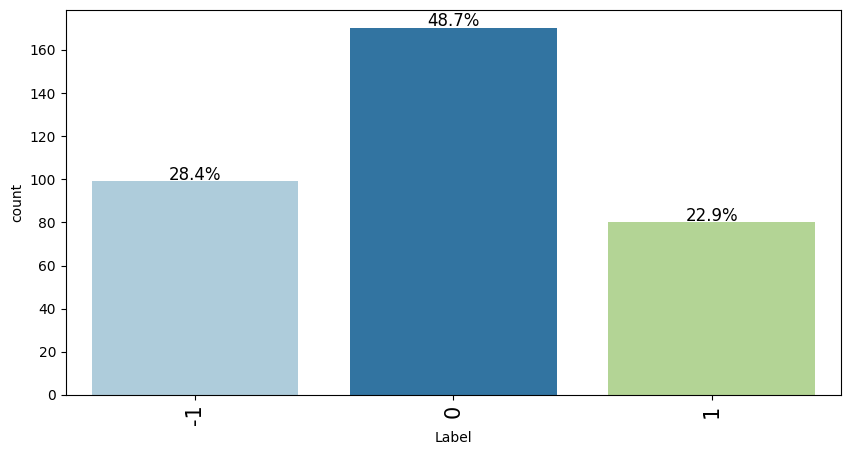

In [ ]:
# distribution of label
labeled_barplot(data, 'Label', perc=True)

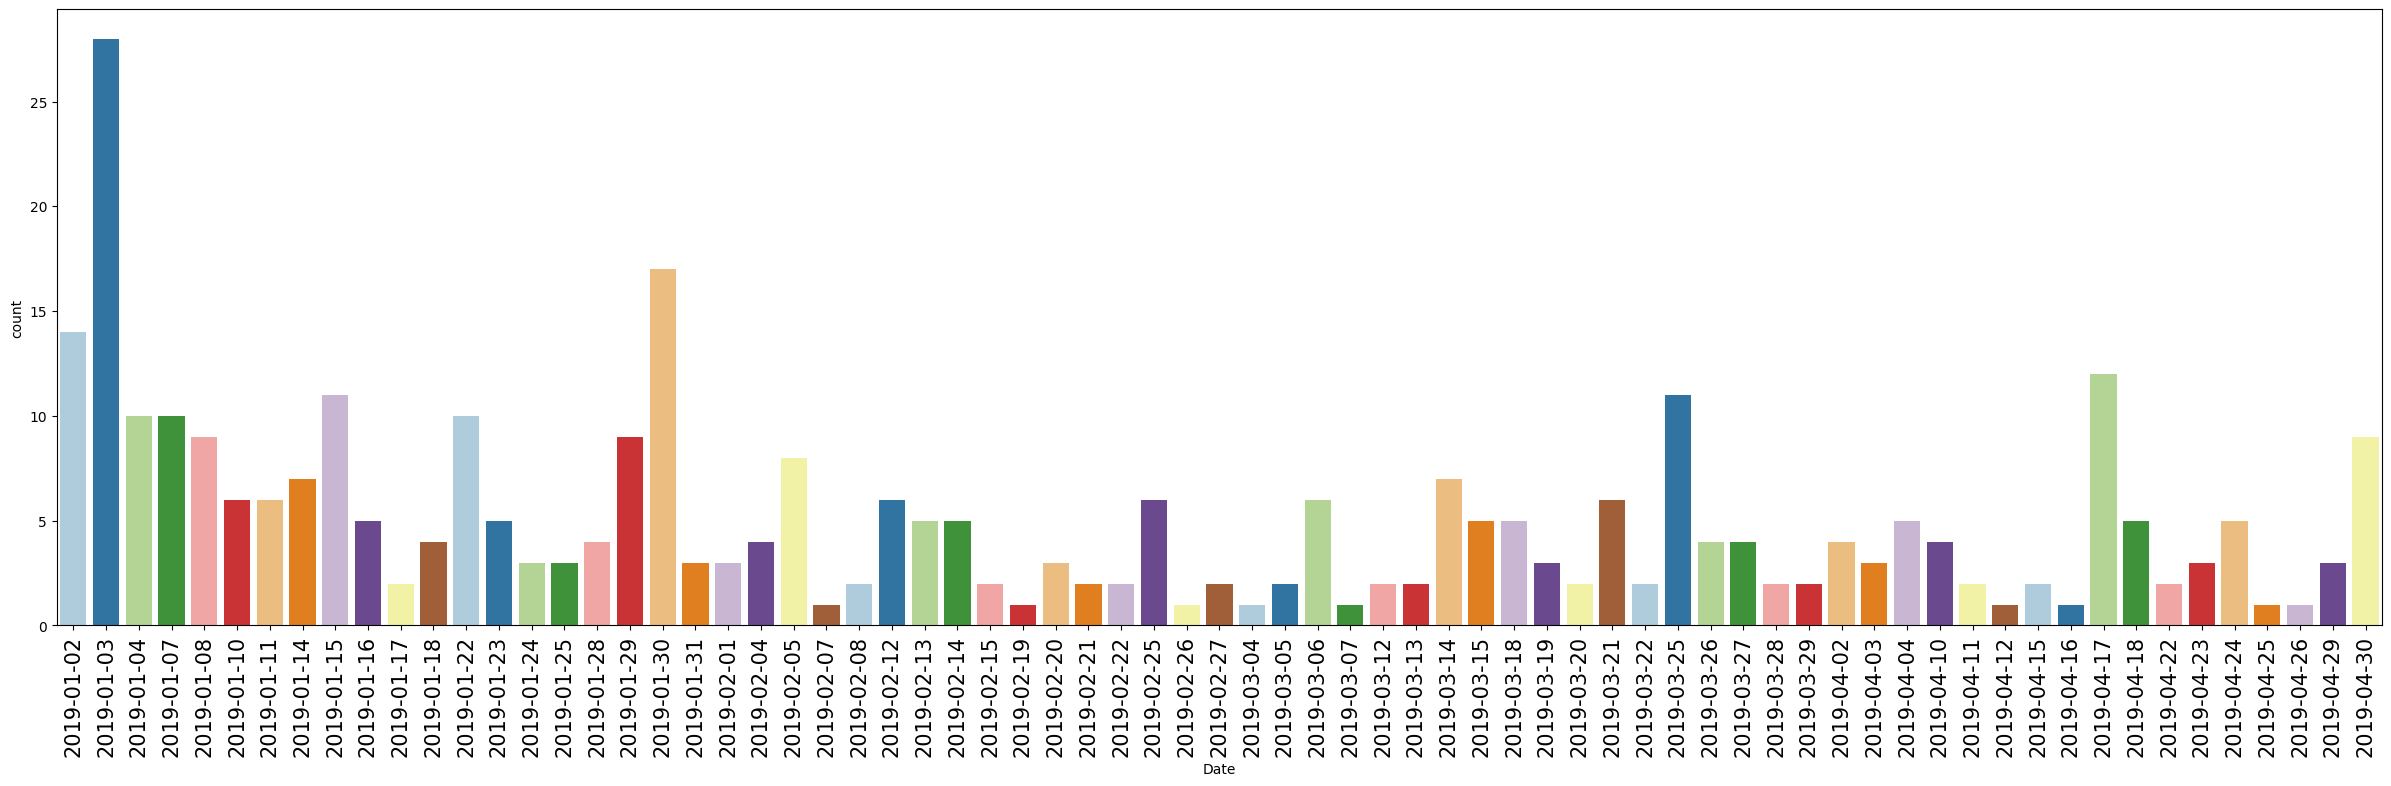

In [ ]:
# distribution of news
labeled_barplot(data, 'Date', figsize=(30, 8), hide_label=True)

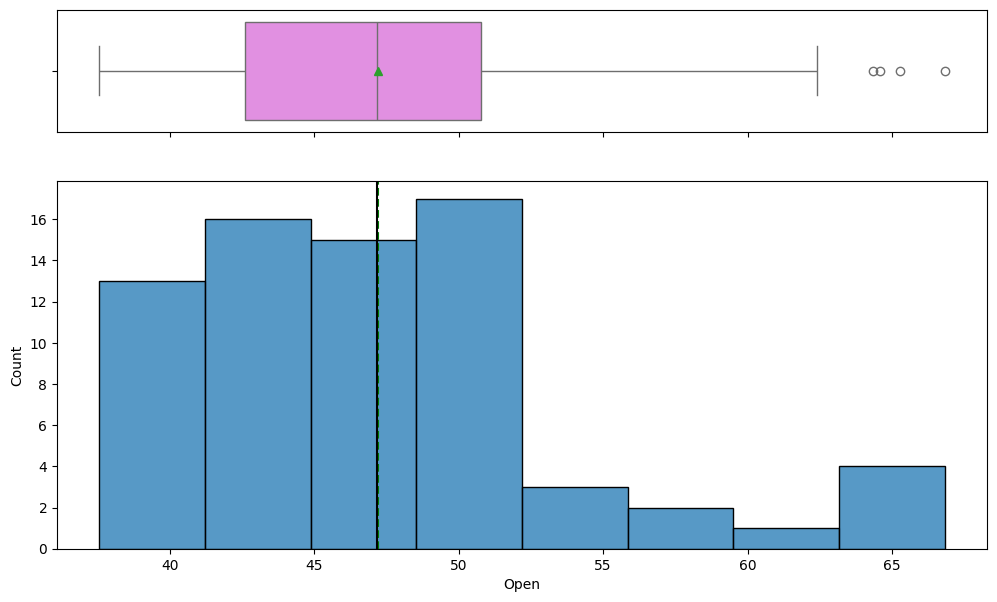

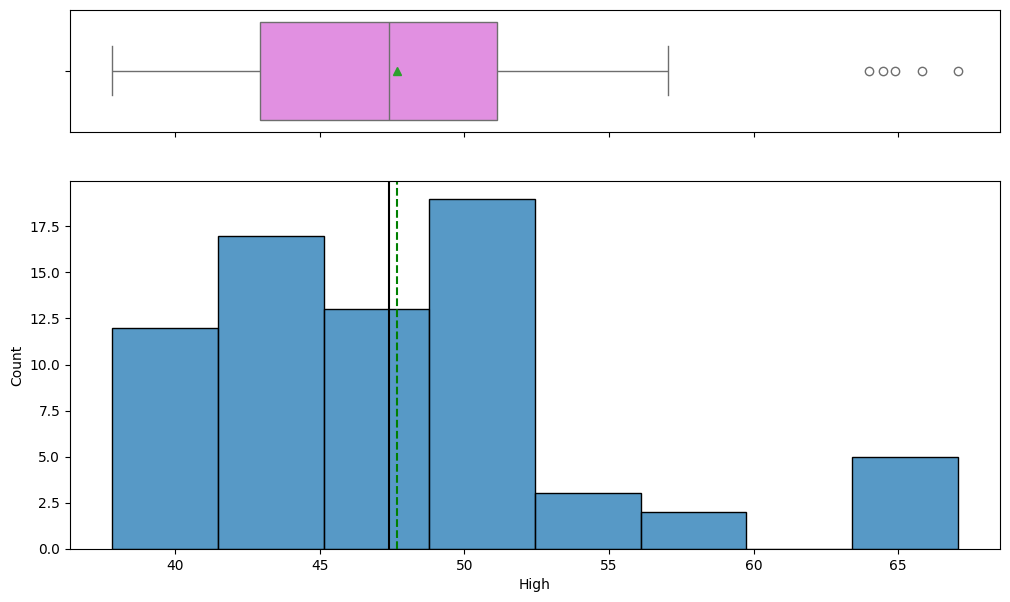

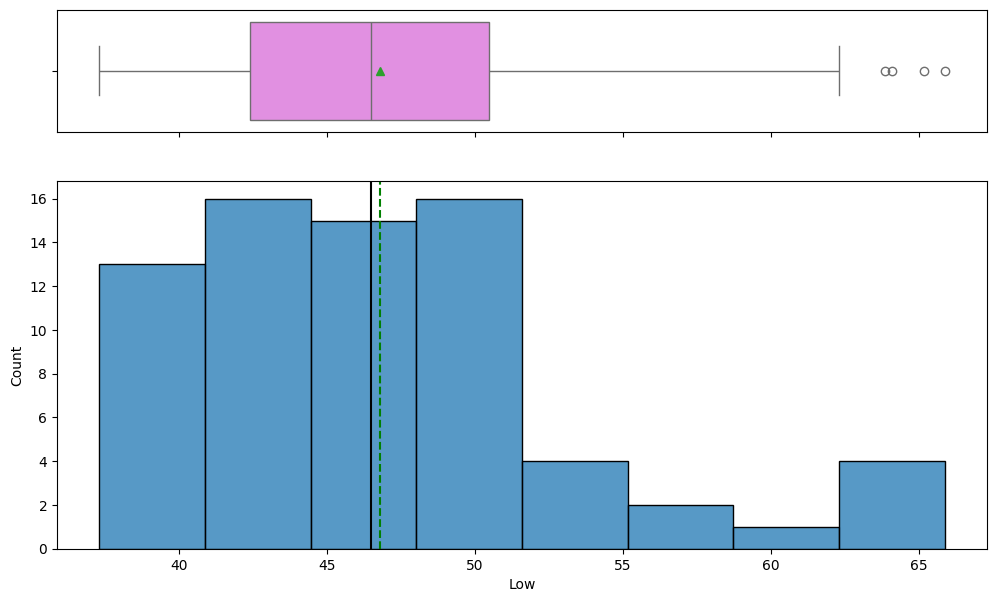

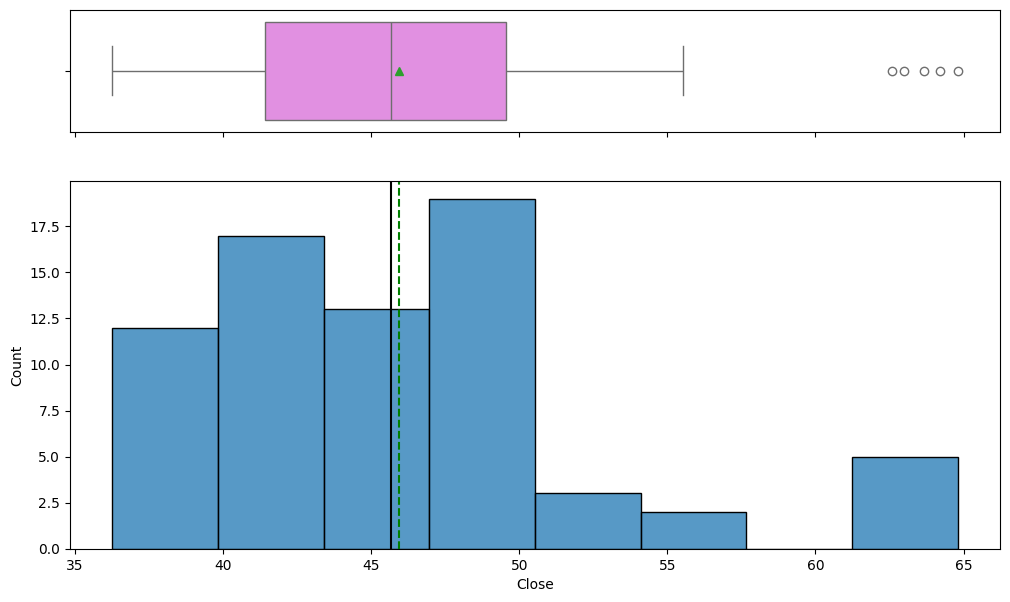

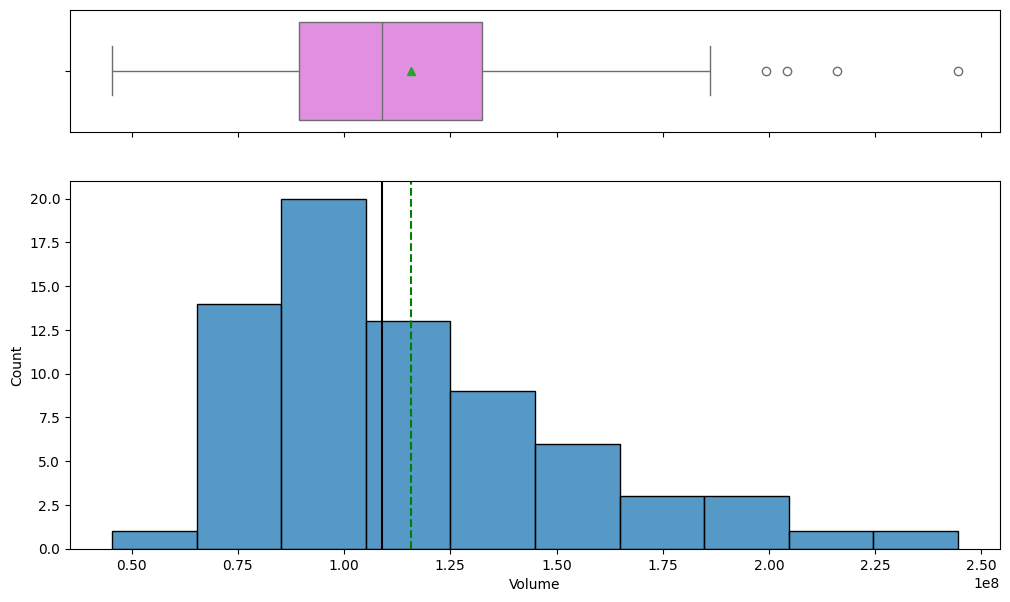

In [ ]:
for col in num_cols:
  histogram_boxplot(DateDeDupedTable, col)

In [ ]:
data['news_length'].describe()

count    349.000000
mean      48.349570
std        5.717324
min       18.000000
25%       45.000000
50%       49.000000
75%       52.000000
max       60.000000
Name: news_length, dtype: float64

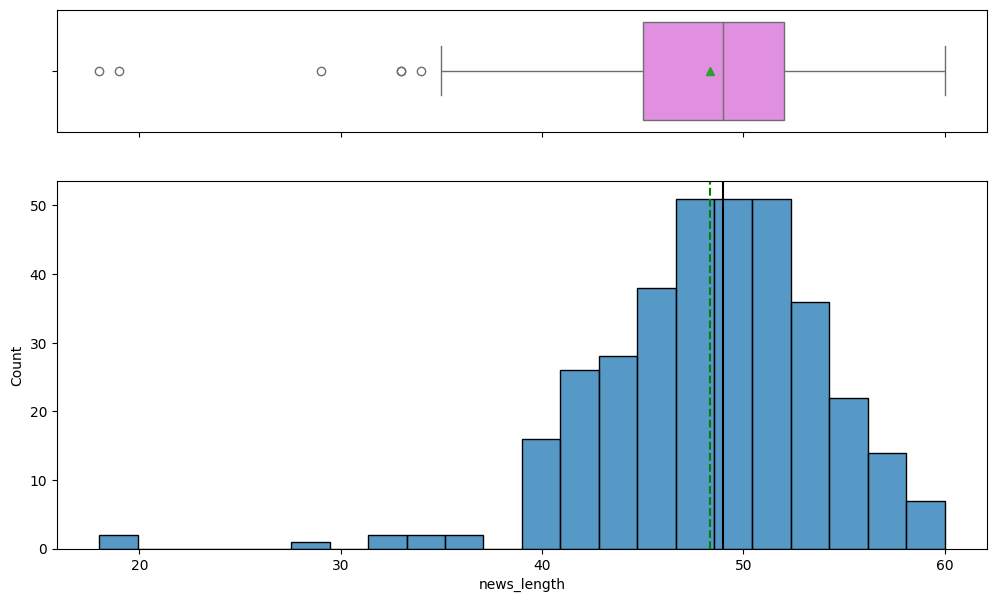

In [ ]:
histogram_boxplot(data, 'news_length')

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

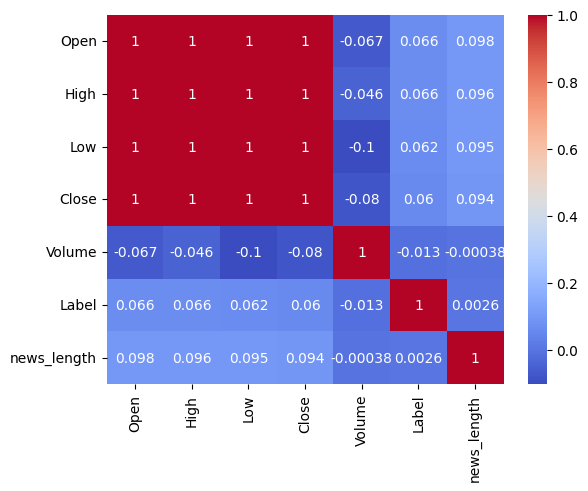

In [ ]:
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.show()

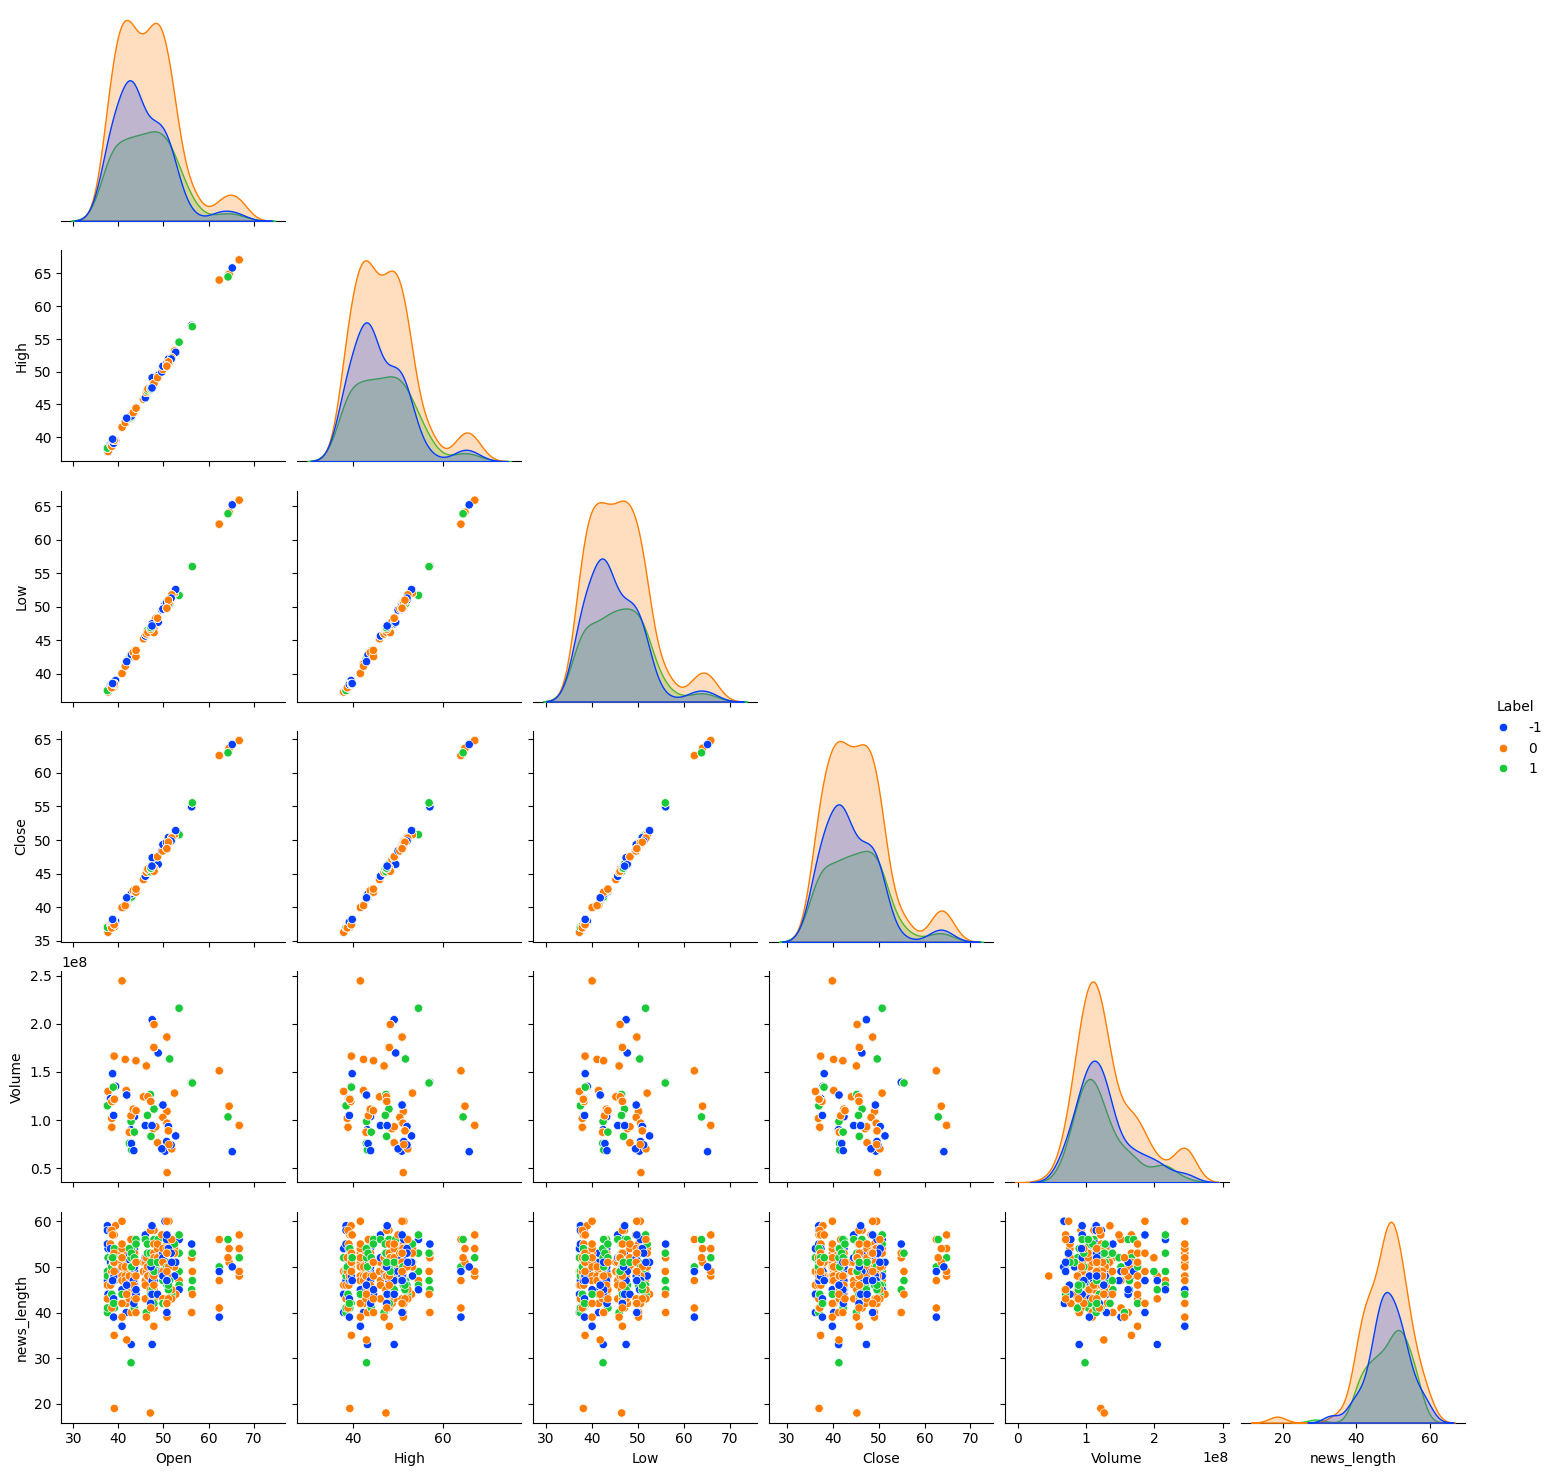

In [ ]:
sns.pairplot(data, hue='Label', palette='bright', corner=True)
plt.show()

We notice that price variables are highly correlated to each other

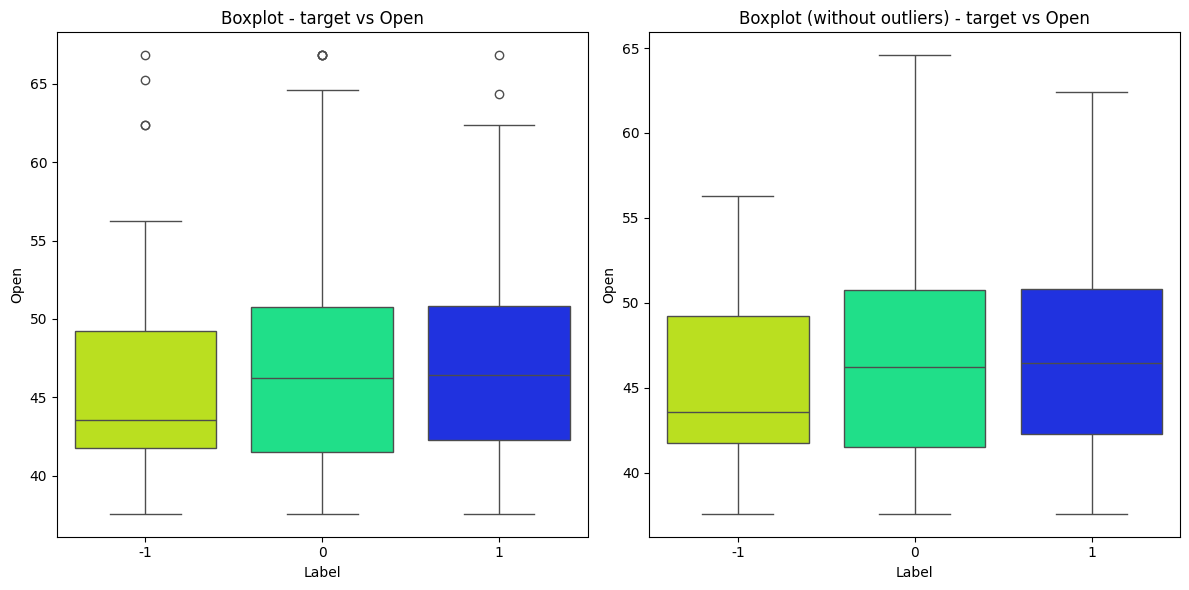

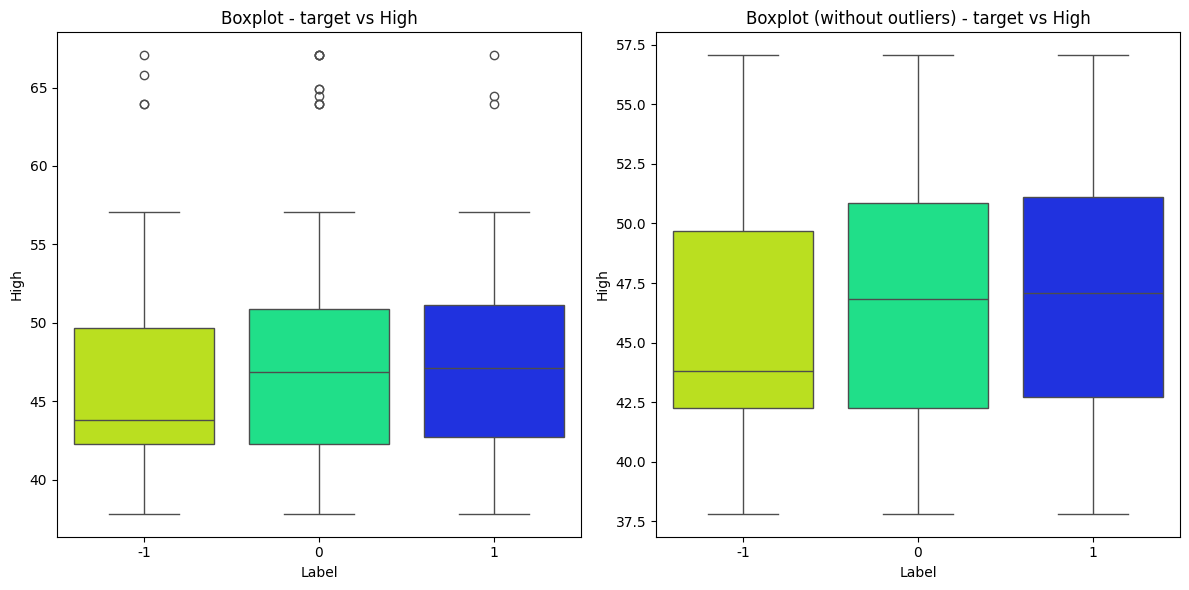

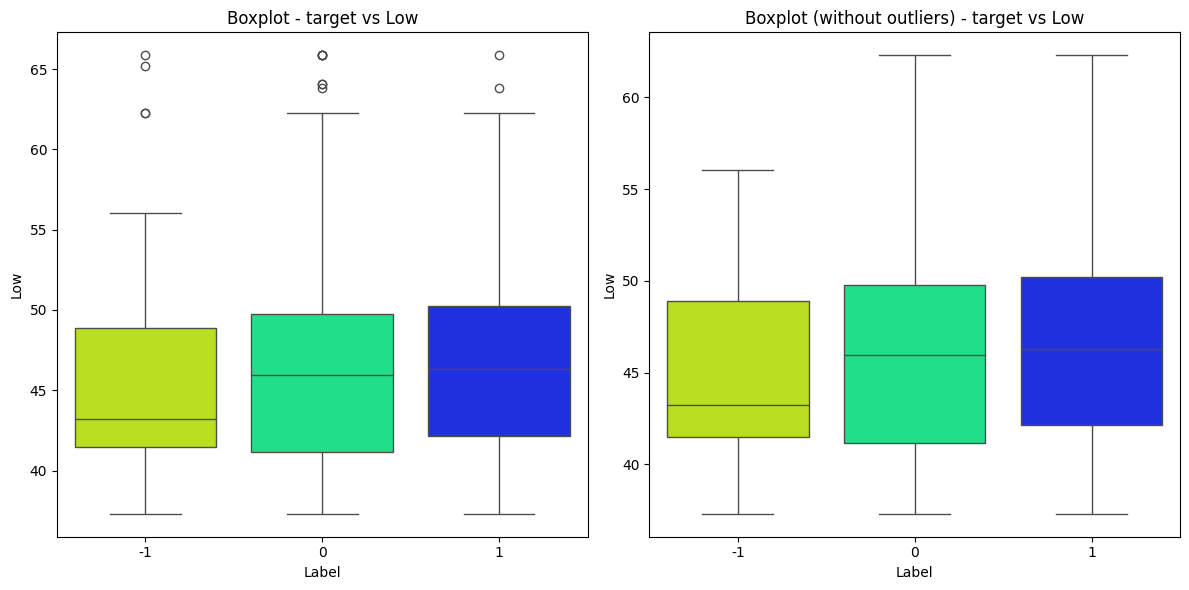

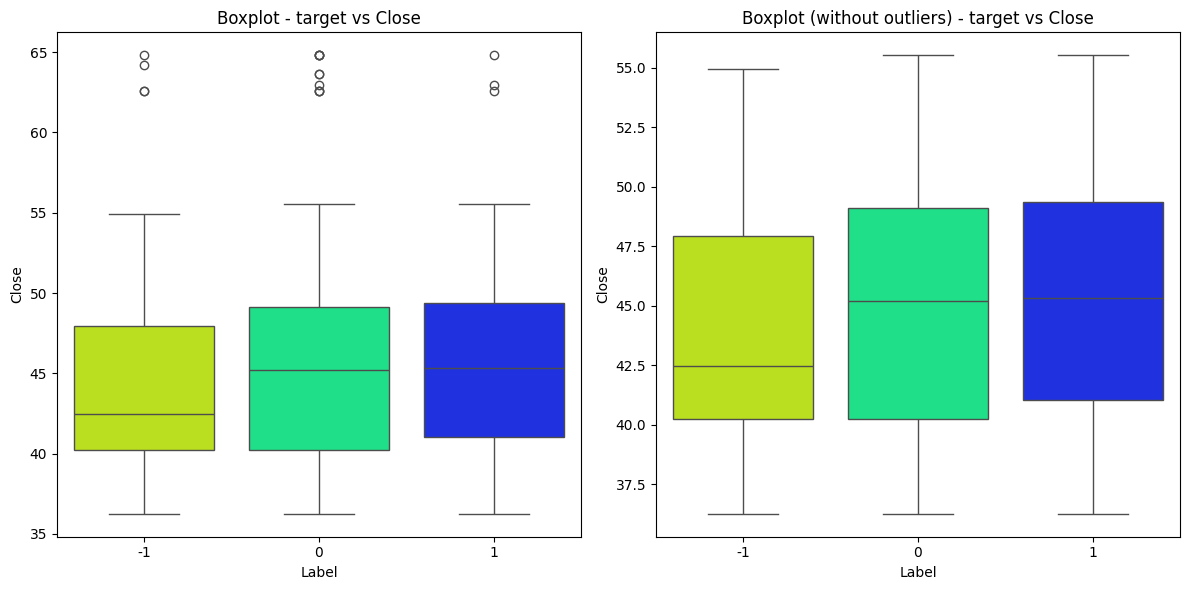

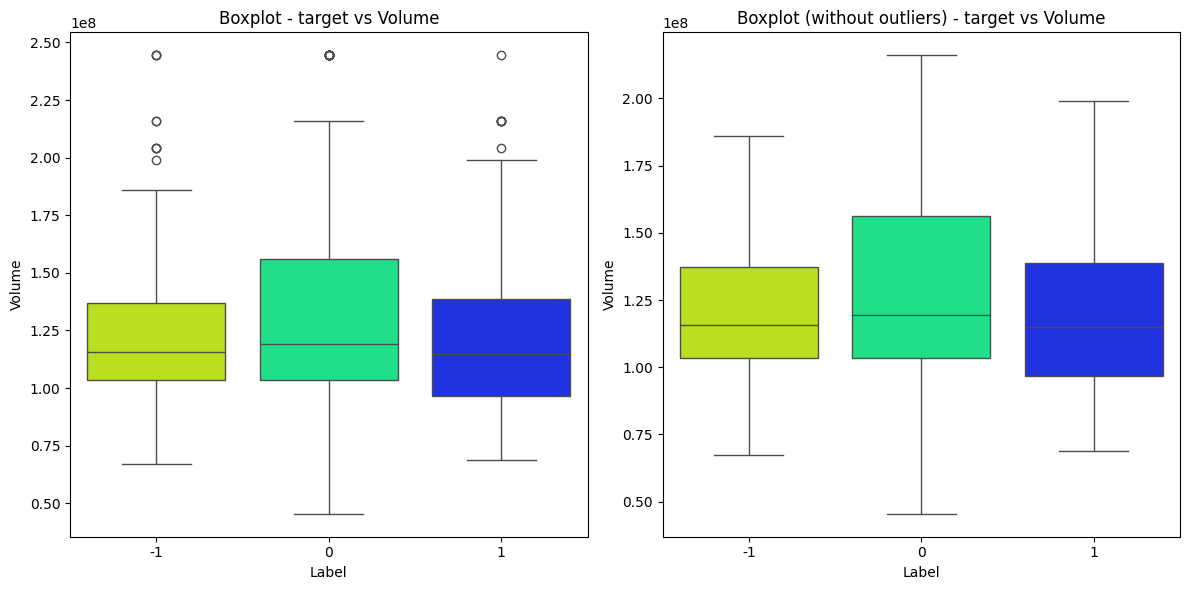

In [ ]:
for col in num_cols:
  distribution_plot_wrt_target(data, col, 'Label')

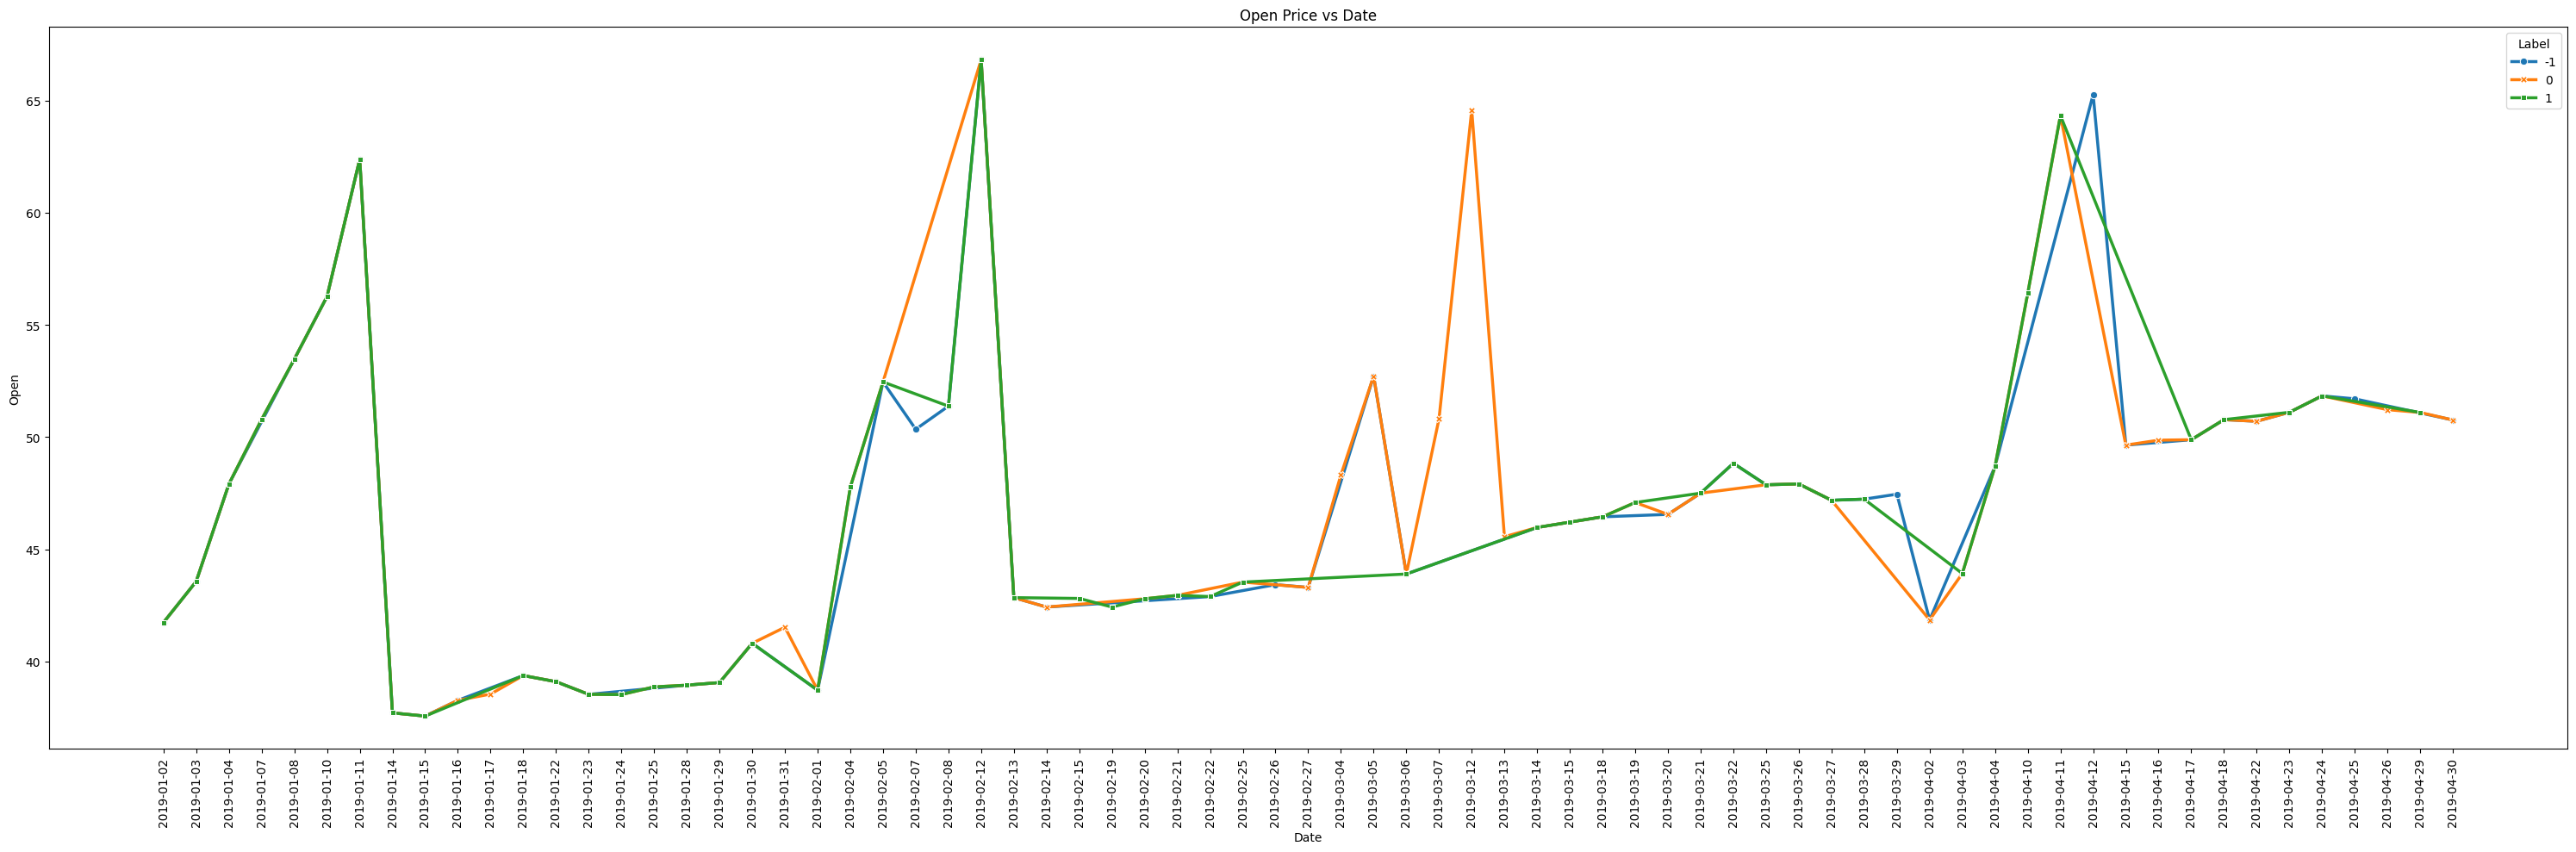

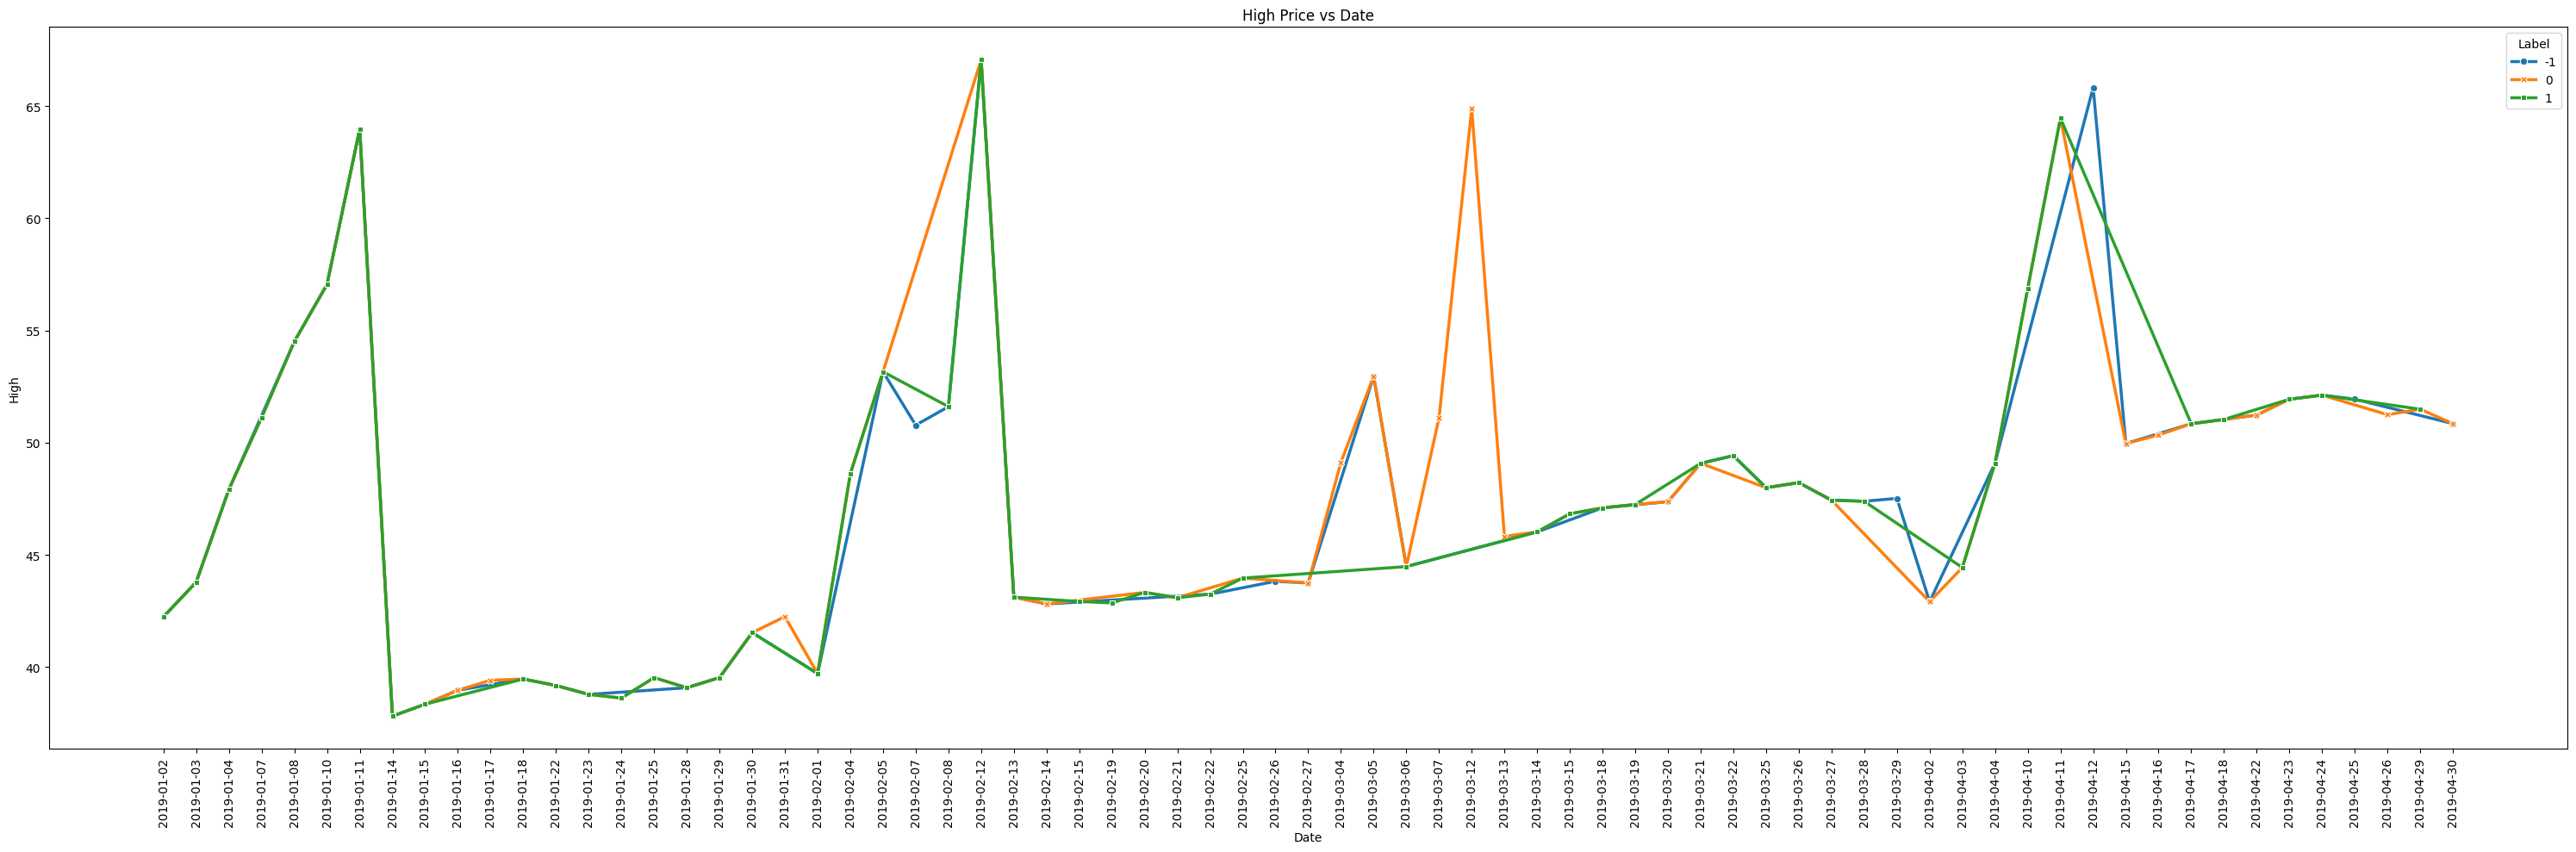

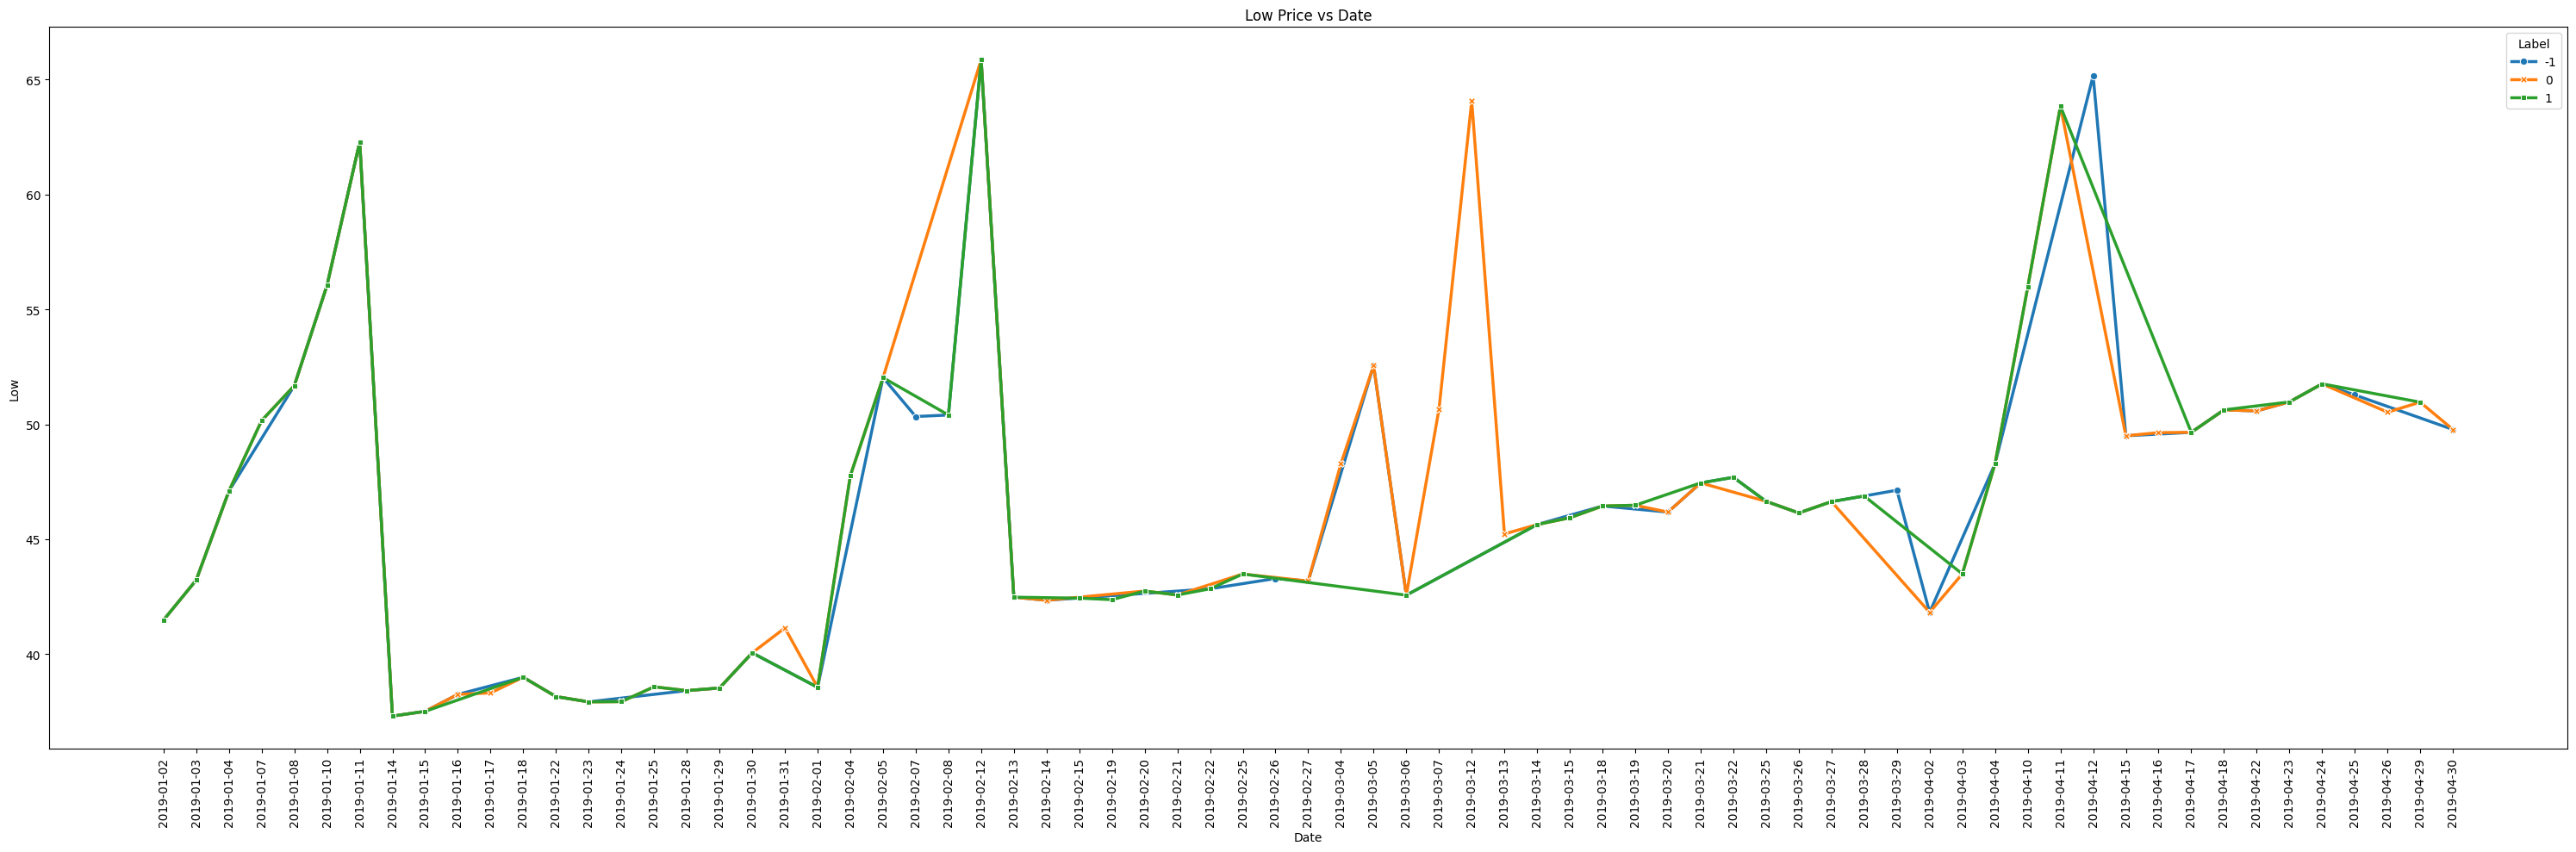

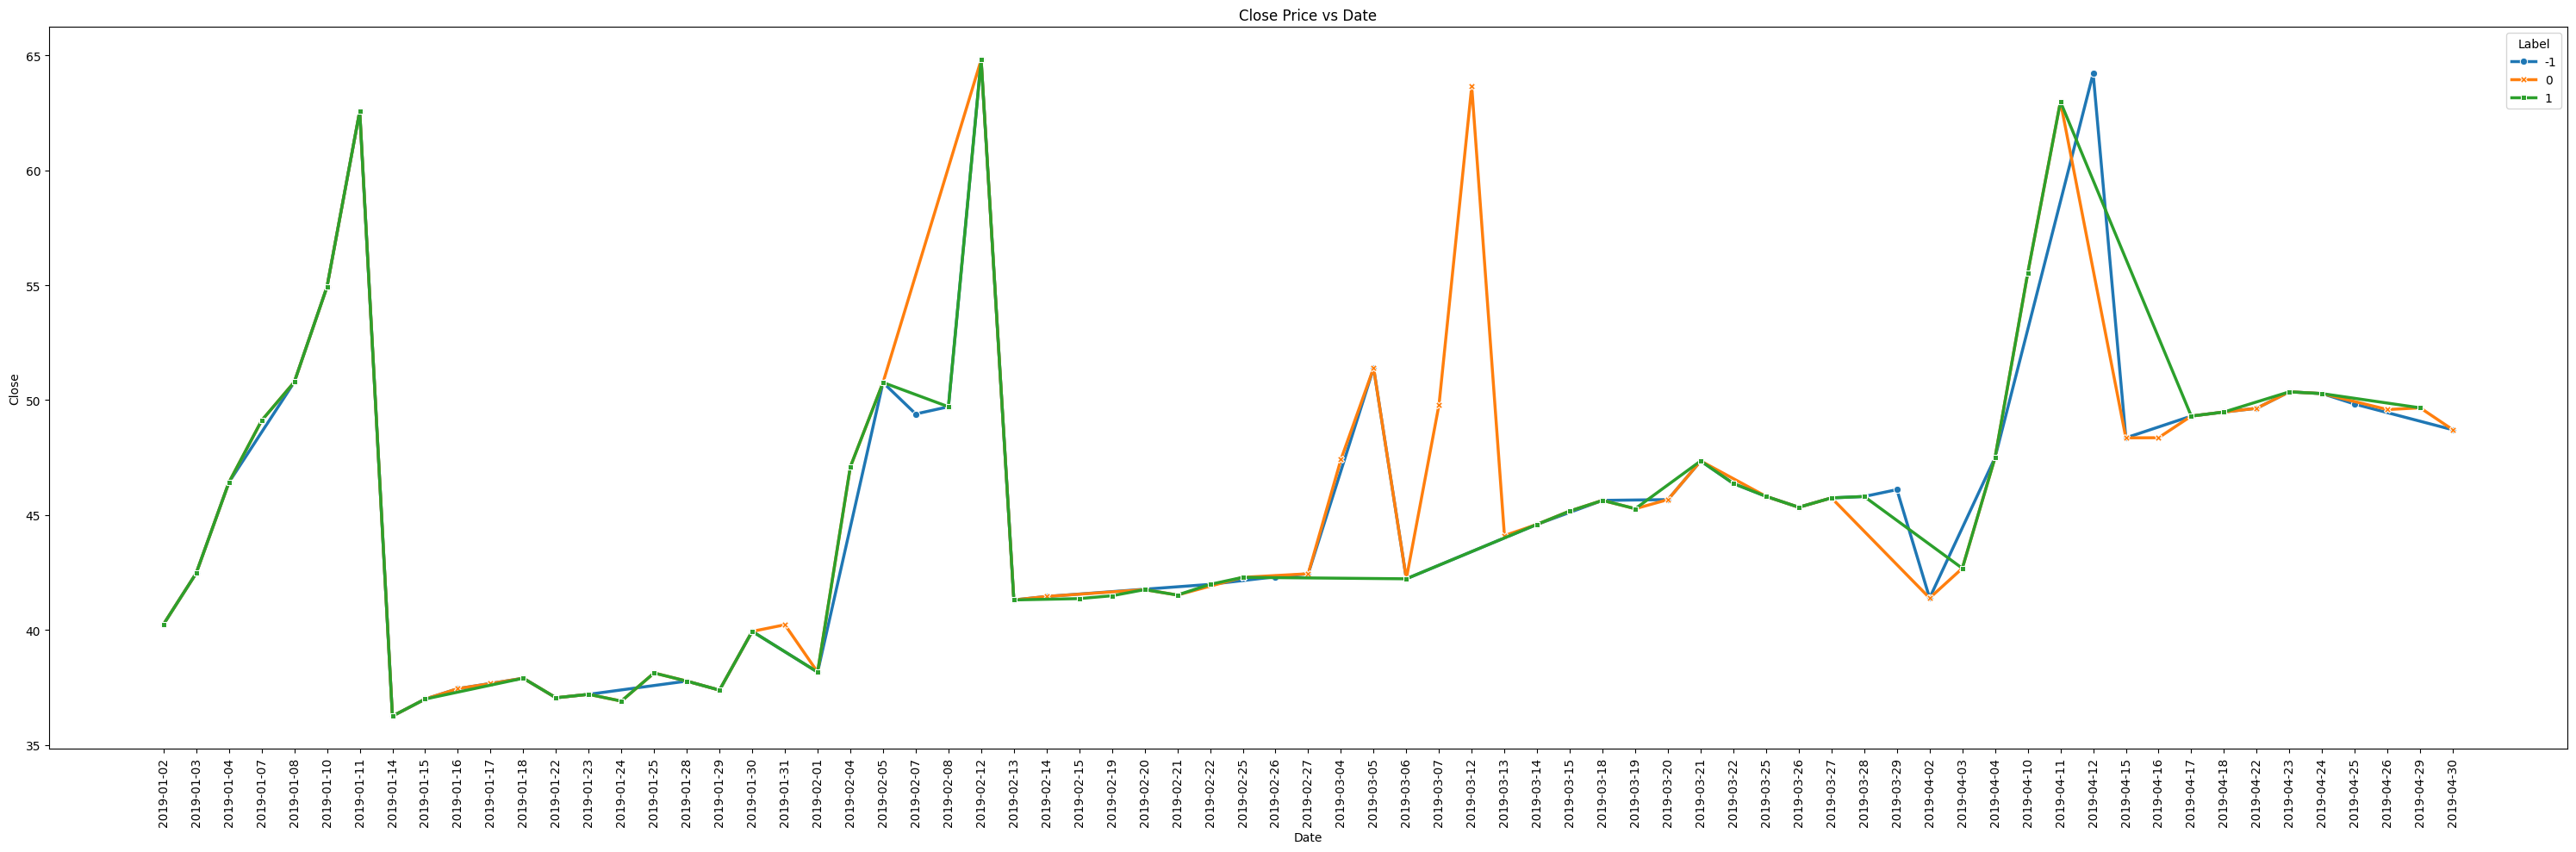

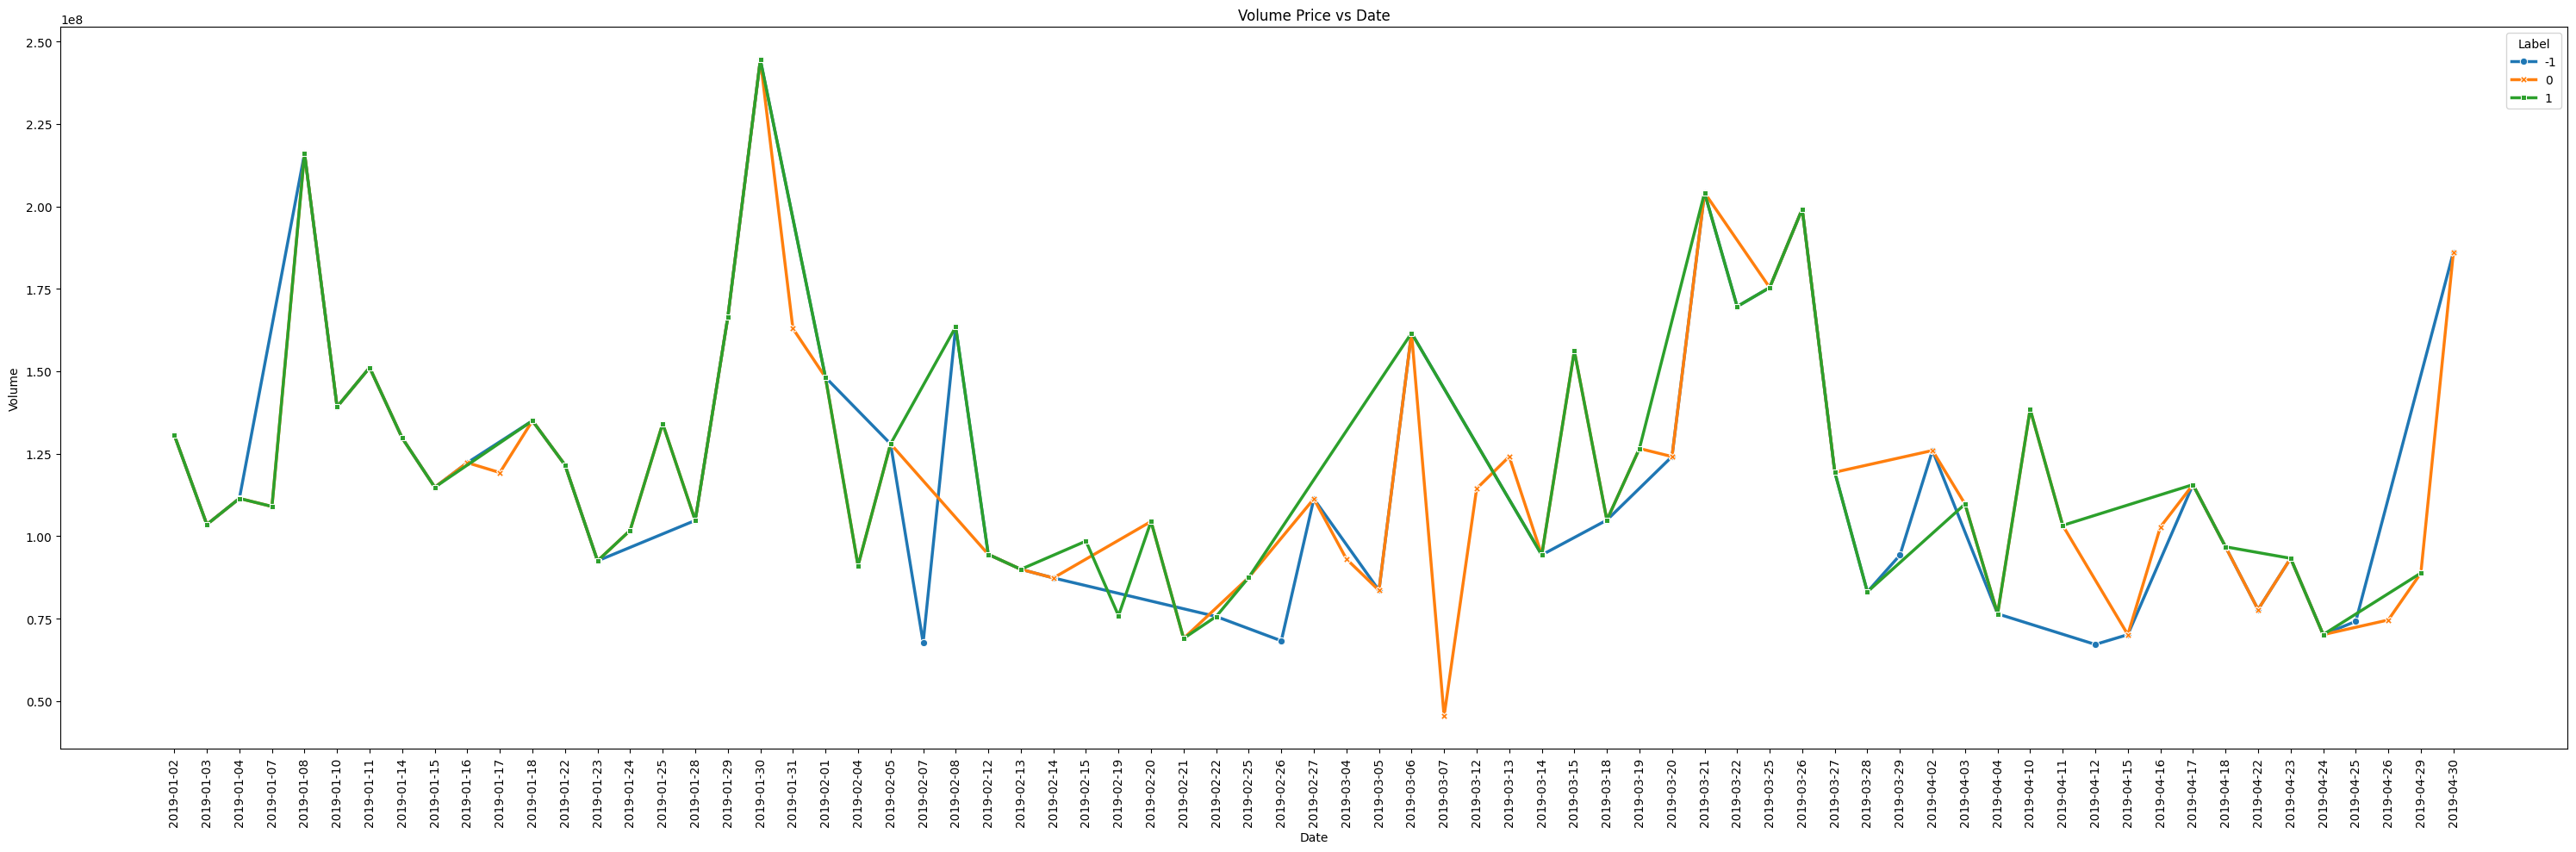

In [ ]:
for col in num_cols:
  plt.figure(figsize=(30, 10))
  sns.lineplot(data=data, x='Date', y=col, hue='Label', style="Label", palette="tab10", errorbar=None, markers=True, dashes=False, linewidth=2.5)
  plt.xticks(rotation=90)
  plt.title(f'{col} Price vs Date')
  plt.tight_layout()
  plt.show()

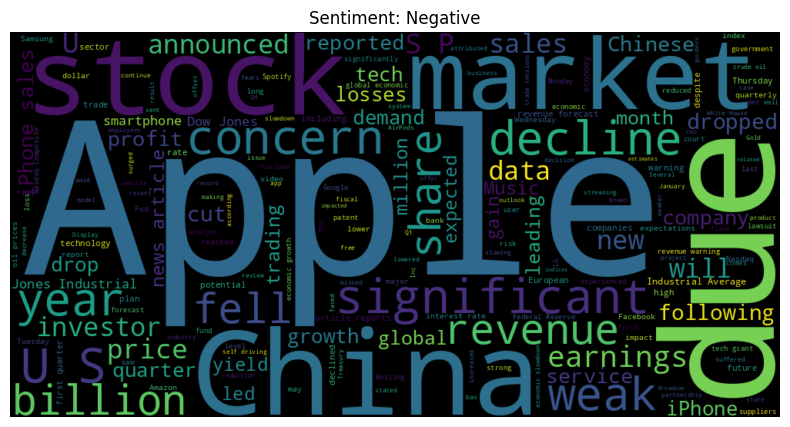

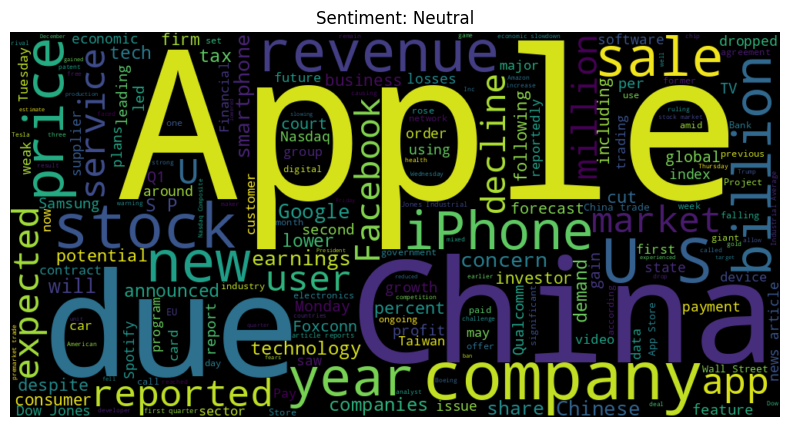

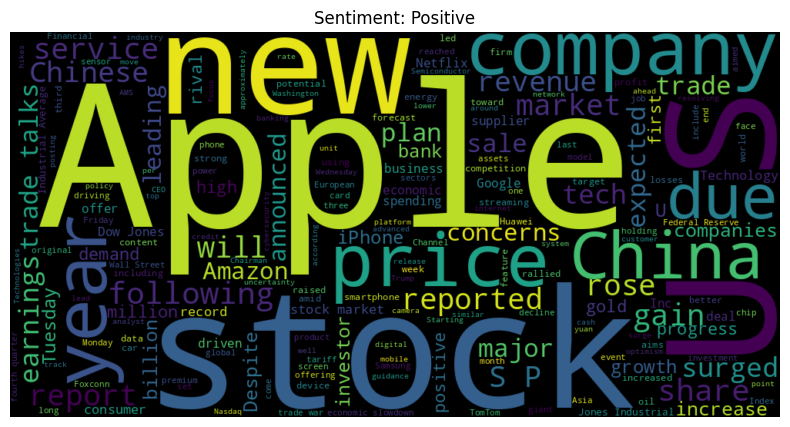

In [ ]:
for sent in [-1, 0, 1]:
  news_text = data[data['Label'] == sent]['News'].tolist()
  combined_text = " ".join(news_text)  # Convert list to a single string
  generate_wordcloud(
    combined_text,
    f"Sentiment: {'Positive' if sent == 1 else 'Neutral' if sent == 0 else 'Negative'}")

### Observations
* We observe that our dataset has 48.7% news with neutral sentiment, 28.4% news with negative sentiment and 22.9% news of positive sentiment.
* The dataset contains news for the company between Jan 2019 and April 2019.
* We notice 3rd Jan 2019 has the highest number of news about the company.
* Average open price is around \\$47 and there are few outliers with the highest open price around \\$66. 75% open price is around \\$42.9 or more.
* 75% of the highest stock price during the day is over \\$42.
* The lowest stock price for the 75th percentile is around \\$50 and 25th percentile is around \\$42
* The average closing price is around \\$45.9 and 75% closing price is around \\$41 or more.
* `Volume` has right skewed distribution. On average 115.7 million stocks are traded per day.
* The average number of word per news is around 48 and some news have very small word count, the word distribution of news is left skewed. 75% news have word count 45 or more.
* We observe that price variables `Open`, `High`, `Low`,`Close` are correlated to each other with correlation score 1. There is no correlation between price and volume
* We observe that when the news sentiment is negative the 75th precentile of opening price, 75th percentile of closing price, 75th precentile of the highest price and 75th percentile of the lowest price are consitently lower compared to when the news sentiment is neutral or positive.
* The line plot shows the effect of news sentiment over time. We notice the price flactuates based on the sentiment of the news.We observe the sentiment of the news has also an impact on the number of shares getting traded for a day.
* We plotted the word cloud against sentiment. We notice words like "significant", "weak", "decline", "concern" are in there for negative sentiment. Words like "revenue", "surged", "gain", "increase" are there for postive sentiment. For neutral sentiment we see words like "revenue", "price", "service" etc. We can see some common words in all 3 word clouds. These include "Apple", "Stock" etc.


## **Data Preprocessing**

### Special Character Removal

In [ ]:
def remove_special_chars(text):
  pattern = '[^A-Za-z0-9]+'
  # replace special character that matches the patter with a black string
  new_text = re.sub(pattern, ' ', text)
  return new_text

data['clean_text'] = data['News'].apply(remove_special_chars)

In [ ]:
data.loc[0:3, ['News', 'clean_text']]

News  \
0   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.   
1    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10   
2                               Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon   
3                           This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple   

                                                                                                                                                                                                                                                                                                                       clean_text  
0     The tech sector experienced a significant decline in the aftermarket following Apple s Q1 revenue warning Notable suppliers including Skyworks Broadcom Lumentum Qorvo and TSMC saw their stocks drop in response to Apple s downward revision of its revenue expectations for the quarter previously announced in January   
1   Apple lowered its fiscal Q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iPhone sales The announcement caused a significant drop in Apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as Nasdaq 10  
2                                Apple cut its fiscal first quarter revenue forecast from 89 93 billion to 84 billion due to weaker demand in China and fewer iPhone upgrades CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks Apple s shares fell 8 5 in post market trading while Asian suppliers like Hon  
3                           This news article reports that yields on long dated U S Treasury securities hit their lowest levels in nearly a year on January 2 2019 due to concerns about the health of the global economy following weak economic data from China and Europe as well as the partial U S government shutdown Apple

### Lower casing and extra whitespace removal

In [ ]:
data['clean_text'] = data['clean_text'].str.lower()
data['clean_text'] = data['clean_text'].str.strip()

In [ ]:
data.loc[0:3, ['News', 'clean_text']]

News  \
0   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.   
1    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10   
2                               Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon   
3                           This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple   

                                                                                                                                                                                                                                                                                                                      clean_text  
0     the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january  
1  apple lowered its fiscal q1 revenue guidance to 84 billion from earlier estimates of 89 93 billion due to weaker than expected iphone sales the announcement caused a significant drop in apple s stock price and negatively impacted related suppliers leading to broader market declines for tech indices such as nasdaq 10  
2                               apple cut its fiscal first quarter revenue forecast from 89 93 billion to 84 billion due to weaker demand in china and fewer iphone upgrades ceo tim cook also mentioned constrained sales of airpods and macbooks apple s shares fell 8 5 in post market trading while asian suppliers like hon  
3                          this news article reports that yields on long dated u s treasury securities hit their lowest levels in nearly a year on january 2 2019 due to concerns about the health of the global economy following weak economic data from china and europe as well as the partial u s government shutdown apple

### Stopword removal

In [ ]:
def remove_stopwords(text):
  words = text.split()
  new_text = [word for word in words if word not in STOPWORDS]
  return ' '.join(new_text)

data['clean_text'] = data['clean_text'].apply(remove_stopwords)

In [ ]:
data.loc[0:3, ['News','clean_text']]

News  \
0   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.   
1    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10   
2                               Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon   
3                           This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple   

                                                                                                                                                                                                                                                                    clean_text  
0  tech sector experienced significant decline aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo tsmc saw stocks drop response apple s downward revision revenue expectations quarter previously announced january  
1   apple lowered fiscal q1 revenue guidance 84 billion earlier estimates 89 93 billion due weaker expected iphone sales announcement caused significant drop apple s stock price negatively impacted related suppliers leading broader market declines tech indices nasdaq 10  
2                             apple cut fiscal first quarter revenue forecast 89 93 billion 84 billion due weaker demand china fewer iphone upgrades ceo tim cook mentioned constrained sales airpods macbooks apple s shares fell 8 5 post market trading asian suppliers hon  
3                                          news article reports yields long dated u s treasury securities hit lowest levels nearly year january 2 2019 due concerns health global economy following weak economic data china europe well partial u s government shutdown apple

### Stemming

In [ ]:
ps = PorterStemmer()
def apply_stemming(text):
  words = text.split()
  new_text = [ps.stem(word) for word in words]
  return ' '.join(new_text)

data['clean_text'] = data['clean_text'].apply(apply_stemming)

In [ ]:
data.loc[0:3, ['News','clean_text']]

News  \
0   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.   
1    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10   
2                               Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon   
3                           This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple   

                                                                                                                                                                                                                               clean_text  
0  tech sector experienc signific declin aftermarket follow appl s q1 revenu warn notabl supplier includ skywork broadcom lumentum qorvo tsmc saw stock drop respons appl s downward revis revenu expect quarter previous announc januari  
1         appl lower fiscal q1 revenu guidanc 84 billion earlier estim 89 93 billion due weaker expect iphon sale announc caus signific drop appl s stock price neg impact relat supplier lead broader market declin tech indic nasdaq 10  
2         appl cut fiscal first quarter revenu forecast 89 93 billion 84 billion due weaker demand china fewer iphon upgrad ceo tim cook mention constrain sale airpod macbook appl s share fell 8 5 post market trade asian supplier hon  
3                           news articl report yield long date u s treasuri secur hit lowest level nearli year januari 2 2019 due concern health global economi follow weak econom data china europ well partial u s govern shutdown appl

## **Word Embeddings**

### Word2Vec

In [ ]:
# get the list of the words
words_list = data['clean_text'].apply(lambda x: x.split()).to_list()

In [ ]:
w2v = Word2Vec(words_list, vector_size=300, min_count=1, window=5, workers=6)

In [ ]:
print('Word2Vec vocubulary length:', len(list(w2v.wv.key_to_index)))

Word2Vec vocubulary length: 2581


In [ ]:
w2v.wv.vector_size

300

* Our word2vec vocabulary contains 2581 words and each word is mapped to an embedding vector of size 300

In [ ]:
# function to calculate average embedding of a text content
def average_word_vectorizer(doc):
    feature_vector = np.zeros((300,), dtype="float64")
    n_words = 0
    for word in doc:
        if word in w2v.wv:
            n_words += 1
            feature_vector = np.add(feature_vector, w2v.wv[word])

    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

In [ ]:
df_w2v = pd.DataFrame(data['clean_text'].apply(average_word_vectorizer).to_list(), columns=[f'feature_{i}' for i in range(300)])
df_w2v.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.000404   0.005755   0.000439   0.003363  -0.000795  -0.007498   
1   0.000419   0.004555   0.000063   0.002774  -0.000638  -0.005749   
2   0.000362   0.004935   0.000331   0.003146  -0.000733  -0.006336   
3   0.000135   0.004277   0.000467   0.003010  -0.001044  -0.005246   
4   0.000495   0.005586   0.000452   0.003362  -0.000812  -0.007048   

   feature_6  feature_7  feature_8  feature_9  ...  feature_290  feature_291  \
0   0.005780   0.013907   0.001364  -0.000406  ...     0.001522     0.007306   
1   0.004442   0.011243   0.001127   0.000136  ...     0.001416     0.006021   
2   0.004592   0.011757   0.001244  -0.000213  ...     0.001127     0.006428   
3   0.004393   0.010888   0.001324  -0.000150  ...     0.001128     0.005841   
4   0.005300   0.013189   0.001420  -0.000265  ...     0.001276     0.007026   

   feature_292  feature_293  feature_294  feature_295  feature_296  \
0     0.006428     0.000143     0.006561     0.007284    -0.000116   
1     0.005128     0.000421     0.005110     0.005893    -0.000242   
2     0.005438     0.000468     0.005530     0.006506    -0.000200   
3     0.004642     0.000512     0.004521     0.005678    -0.000097   
4     0.006009     0.000456     0.006003     0.007094    -0.000204   

   feature_297  feature_298  feature_299  
0    -0.003522     0.005115    -0.002716  
1    -0.002862     0.003799    -0.002187  
2    -0.003047     0.004104    -0.002249  
3    -0.002515     0.003267    -0.001799  
4    -0.003418     0.004838    -0.002508  

[5 rows x 300 columns]

In [ ]:
df_w2v.shape

(349, 300)

* By taking an average embedding of all word for a news, we now have embedding for every news in the dataset.

### GLoVe

In [ ]:
glove_file_name = '/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(glove_file_name, binary=False)

In [ ]:
glove_model.vector_size

100

In [ ]:
print('GloVe model vocabulary length:', len(list(glove_model.key_to_index)))

GloVe model vocabulary length: 400000


* Our GloVe model vocbulary contains 400000 words and each word is mapped to an embedding vector of size 100

In [ ]:
def average_word_vectorizer_glove(doc):
    feature_vector = np.zeros((100,), dtype="float64")
    n_words = 0
    for word in doc:
        if word in glove_model:
            n_words += 1
            feature_vector = np.add(feature_vector, glove_model[word])

    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

In [ ]:
df_glove = pd.DataFrame(data['clean_text'].apply(average_word_vectorizer_glove).to_list(), columns=[f'feature_{i}' for i in range(100)])
df_glove.head()

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -0.438059   0.396038   0.146362  -0.091754  -0.351164   0.127013   
1  -0.406294   0.433794   0.134785  -0.101269  -0.363750   0.154487   
2  -0.389492   0.389011   0.121072  -0.111992  -0.352349   0.144370   
3  -0.407803   0.368171   0.095459  -0.130723  -0.303190   0.151995   
4  -0.410051   0.389202   0.161779  -0.103599  -0.354772   0.134764   

   feature_6  feature_7  feature_8  feature_9  ...  feature_90  feature_91  \
0   0.259203   0.192984  -0.471091   0.202774  ...   -0.568583    0.531836   
1   0.292141   0.191788  -0.461706   0.155542  ...   -0.545342    0.471339   
2   0.276948   0.209861  -0.452054   0.188272  ...   -0.498726    0.472870   
3   0.283307   0.189956  -0.405769   0.163380  ...   -0.524662    0.456668   
4   0.272047   0.192308  -0.452243   0.178896  ...   -0.554634    0.463087   

   feature_92  feature_93  feature_94  feature_95  feature_96  feature_97  \
0    0.308083    0.474471   -0.042943   -0.102868   -0.003118   -0.574618   
1    0.272969    0.422274   -0.080787   -0.045601    0.008295   -0.533765   
2    0.264713    0.430594   -0.081403   -0.082737   -0.013901   -0.544543   
3    0.310701    0.423675   -0.011291   -0.105793   -0.032961   -0.577417   
4    0.273614    0.459674   -0.071780   -0.064516   -0.027998   -0.538030   

   feature_98  feature_99  
0    0.217758   -0.221267  
1    0.224745   -0.147545  
2    0.232118   -0.150713  
3    0.268975   -0.189217  
4    0.234344   -0.183280  

[5 rows x 100 columns]

In [ ]:
df_glove.shape

(349, 100)

* We now have GloVe vector embeddings for each news entry in our dataset

### Sentence Transformer
* We will use sentence-transformers/all-MiniLM-L6-v2. It maps sentences & paragraphs to a 384 dimensional dense vector space
* all-MiniLM-L6-v2 is	an all-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs.The size of the model is just 80 MB and it has speed benchmark score 14200 (source: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html)
* Sentecce transformer models do not require stopword removal, stemming, lowercasing. These models are based on Transformer architectures and use contextual embeddings, meaning they capture the meaning of words based on their usage in a sentence rather than treating words independently.

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# embedding using sentence transformer:
# to save GPU/CPU load we will save the embeddings after encoding
# we will load saved encoding
file_path = '/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/sentence_embeddings.npy'
if not os.path.exists(file_path):
  embeddings = model.encode(data['News'], device=device, show_progress_bar=True)
  np.save('/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/sentence_embeddings.npy', embeddings)
loaded_embeddings = np.load('/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/sentence_embeddings.npy')
loaded_embeddings.shape

(349, 384)

* We have sentence transformer embedding verctor of size 384 for each news entry

## **Sentiment Analysis**

### Utility code for model building

In [ ]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted, labels=['Neutral', 'Positive', 'Negative'], title='Confusion Matrix'):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = labels
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

### Sentiment Analysis model using Word2Vec

#### RandomForest

In [ ]:
# independent and dependent variable initialization
X = df_w2v
y = data['Label']

* As our dataset is small, for RandomForest model we will set `oob_score` true. `oob_score` (Out-of-Bag Score) is a validation accuracy estimate in Random Forest, calculated using the data samples that were not included in the bootstrap training of each tree.

In [ ]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((244, 300), (105, 300))

In [ ]:
# target variable remapping
y_train = y_train.map({0:0, 1:1, -1:2})
y_test = y_test.map({0:0, 1:1, -1:2})

In [ ]:
y_train.value_counts()

Label
0    119
2     69
1     56
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

Label
0    51
2    30
1    24
Name: count, dtype: int64

* Word2Vec embedding can have different magnitude of embeddings, we will scale the input to have consistency.
* We observe that our data is imbalanced, we will calculate the class weight to address this

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
class_weight = compute_class_weight(class_weight='balanced', y = y_train, classes=np.unique(y_train))
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 0.6834733893557423, 1: 1.4523809523809523, 2: 1.178743961352657}

In [ ]:
rf_w2v = RandomForestClassifier(random_state=42, class_weight=class_weight, n_jobs=-1, oob_score=True, bootstrap=True)
rf_w2v.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 0.6834733893557423,
                                     1: 1.4523809523809523,
                                     2: 1.178743961352657},
                       n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
y_train_pred = rf_w2v.predict(X_train_scaled)
y_test_pred = rf_w2v.predict(X_test_scaled)

In [ ]:
df_models =  pd.DataFrame({'train':[accuracy_score(y_train, y_train_pred)], 'validation': [rf_w2v.oob_score_], 'test': [accuracy_score(y_test, y_test_pred)]}, index = ["RF_W2V"])
df_models

train  validation      test
RF_W2V    1.0    0.491803  0.447619

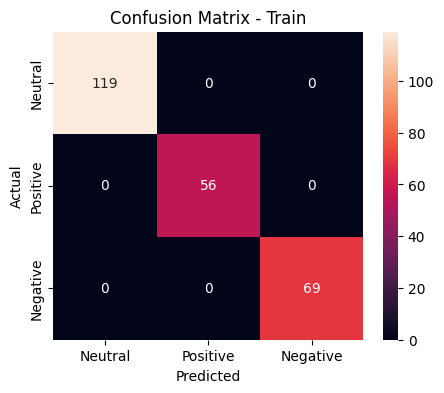

In [ ]:
plot_confusion_matrix(y_train, y_train_pred, title='Confusion Matrix - Train')

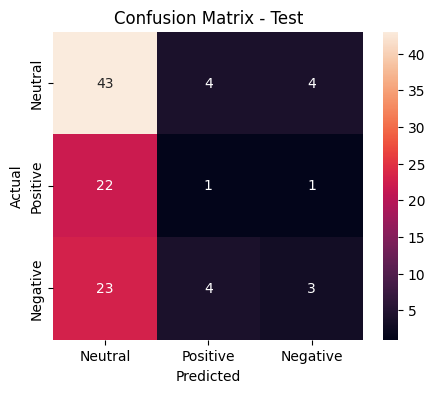

In [ ]:
plot_confusion_matrix(y_test, y_test_pred, title='Confusion Matrix - Test')

In [ ]:
# Classification Report - Train
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        69

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



In [ ]:
# Classification Report - Test
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.49      0.84      0.62        51
           1       0.11      0.04      0.06        24
           2       0.38      0.10      0.16        30

    accuracy                           0.45       105
   macro avg       0.32      0.33      0.28       105
weighted avg       0.37      0.45      0.36       105



* We observe that our model achieves 100% accuracy in training set, estimated accuracy 49% in validation set and 45% accuracy in test set.
* The model overfits.
* We will tune hyper-parameter of RandomForest model to see whether we can improve the overfitting


In [ ]:
params = {
    'n_estimators': [30,40,50],
    'max_depth': [1,2,3],
    'min_samples_split': [4,5,6],
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [5,7],
    'ccp_alpha':[0.07],
    'oob_score':[True],
    'bootstrap':[True]
}
rf_w2v = RandomForestClassifier(random_state=42, class_weight=class_weight, n_jobs=-1, oob_score=True, bootstrap=True)

In [ ]:
random_search = RandomizedSearchCV(
    n_iter = 30,
    estimator = rf_w2v,
    param_distributions=params,
    cv=5,
    random_state=42,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1

)
random_search.fit(X_train_scaled, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)
best_model = random_search.best_estimator_
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'oob_score': True, 'n_estimators': 40, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_depth': 3, 'criterion': 'entropy', 'ccp_alpha': 0.07, 'bootstrap': True}
Best Accuracy: 0.38137755102040816


In [ ]:
df_models = pd.concat([df_models, pd.DataFrame({'train':[accuracy_score(y_train, y_train_pred)], 'validation': [best_model.oob_score_],'test': [accuracy_score(y_test, y_test_pred)]}, index = ["RF_W2V_Tuned"])])
df_models

train  validation      test
RF_W2V        1.000000    0.491803  0.447619
RF_W2V_Tuned  0.614754    0.323770  0.447619

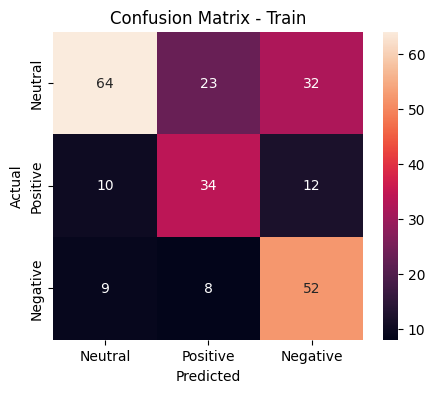

In [ ]:
plot_confusion_matrix(y_train, y_train_pred, title='Confusion Matrix - Train')

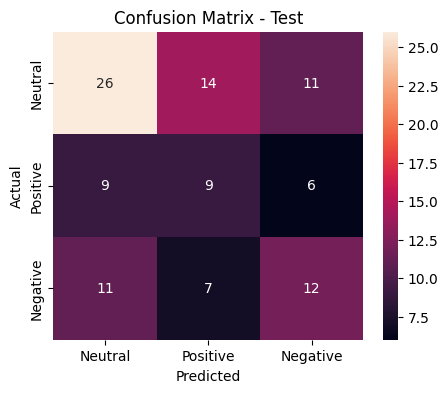

In [ ]:
plot_confusion_matrix(y_test, y_test_pred, title='Confusion Matrix - Test')

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.77      0.54      0.63       119
           1       0.52      0.61      0.56        56
           2       0.54      0.75      0.63        69

    accuracy                           0.61       244
   macro avg       0.61      0.63      0.61       244
weighted avg       0.65      0.61      0.62       244



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.57      0.51      0.54        51
           1       0.30      0.38      0.33        24
           2       0.41      0.40      0.41        30

    accuracy                           0.45       105
   macro avg       0.43      0.43      0.43       105
weighted avg       0.46      0.45      0.45       105



* After tuning the hyperparameters of the model, we achieve 61% accuracy in the training set and 45% accuracy in the test set.

#### Support Vector Machine (SVM)

* We will create a validation set for SVM model

In [ ]:
# independent and dependent variable initialization
X = df_w2v
y = data['Label']

In [ ]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [ ]:
# target variable remapping
y_train = y_train.map({0:0, 1:1, -1:2})
y_test = y_test.map({0:0, 1:1, -1:2})
y_val = y_val.map({0:0, 1:1, -1:2})

In [ ]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(Label
 0    83
 2    48
 1    39
 Name: count, dtype: int64,
 Label
 0    36
 2    21
 1    17
 Name: count, dtype: int64,
 Label
 0    51
 2    30
 1    24
 Name: count, dtype: int64)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((170, 300), (74, 300), (105, 300))

In [ ]:
class_weight = compute_class_weight(class_weight='balanced', y = y_train, classes=np.unique(y_train))
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 0.6827309236947792, 1: 1.452991452991453, 2: 1.1805555555555556}

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
svm_model = SVC(class_weight=class_weight,random_state=42, decision_function_shape='ovo')
svm_model.fit(X_train_scaled, y_train)

SVC(class_weight={0: 0.6827309236947792, 1: 1.452991452991453,
                  2: 1.1805555555555556},
    decision_function_shape='ovo', random_state=42)

In [ ]:
y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

In [ ]:
df_models = pd.concat([df_models,pd.DataFrame({'train':accuracy_score(y_train, y_train_pred), 'validation':accuracy_score(y_val, y_val_pred), 'test': accuracy_score(y_test, y_test_pred)}, index = ['W2V_SVM'])])
df_models

train  validation      test
RF_W2V        1.000000    0.491803  0.447619
RF_W2V_Tuned  0.614754    0.323770  0.447619
W2V_SVM       0.682353    0.391892  0.438095

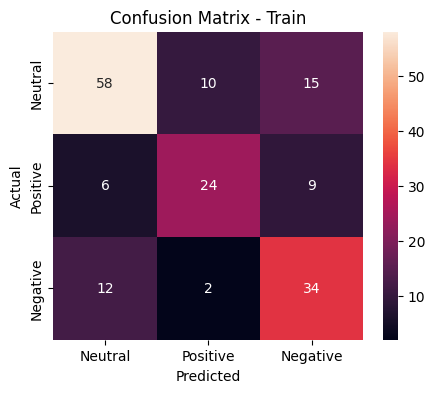

In [ ]:
plot_confusion_matrix(y_train, y_train_pred, title="Confusion Matrix - Train")

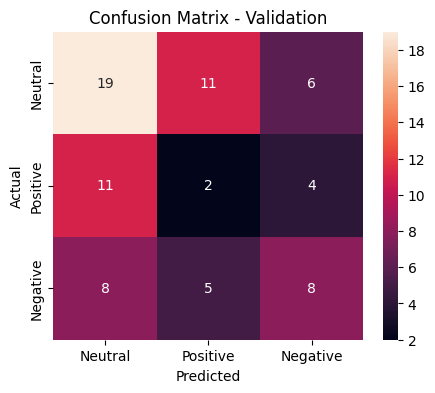

In [ ]:
plot_confusion_matrix(y_val, y_val_pred, title="Confusion Matrix - Validation")

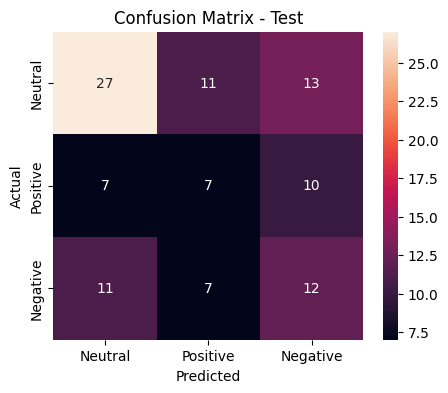

In [ ]:
plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix - Test")

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.76      0.70      0.73        83
           1       0.67      0.62      0.64        39
           2       0.59      0.71      0.64        48

    accuracy                           0.68       170
   macro avg       0.67      0.67      0.67       170
weighted avg       0.69      0.68      0.68       170



In [ ]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.50      0.53      0.51        36
           1       0.11      0.12      0.11        17
           2       0.44      0.38      0.41        21

    accuracy                           0.39        74
   macro avg       0.35      0.34      0.35        74
weighted avg       0.39      0.39      0.39        74



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.60      0.53      0.56        51
           1       0.28      0.29      0.29        24
           2       0.34      0.40      0.37        30

    accuracy                           0.44       105
   macro avg       0.41      0.41      0.41       105
weighted avg       0.45      0.44      0.44       105



* The SVM model gives us 68% accuracy in the training set, 39% accuracy in validation and 44% accuracy in the test set. We will fine tune the model to reduce overfitting.

In [ ]:
svm_model = SVC(class_weight=class_weight,random_state=42, decision_function_shape='ovo')
param_dist = {
     # lower value will reduce overfitting
    'C': np.logspace(-3, -1, 20),
     # used in non-linear kernel, lower value will reduce overfitting
    'gamma': np.logspace(-3, -1, 20),
    'kernel': ['linear', 'rbf']
}
# Train the model with RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'kernel': 'linear', 'gamma': 0.0069519279617756054, 'C': 0.01438449888287663}
Best Accuracy: 0.44110275689223055


In [ ]:
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)
y_test_pred = best_model.predict(X_test_scaled)

In [ ]:
df_models = pd.concat([df_models,
           pd.DataFrame({'train':accuracy_score(y_train, y_train_pred), 'validation':accuracy_score(y_val, y_val_pred), 'test': accuracy_score(y_test, y_test_pred)}, index=['W2V_SVM_Tuned'])])
df_models

train  validation      test
RF_W2V         1.000000    0.491803  0.447619
RF_W2V_Tuned   0.614754    0.323770  0.447619
W2V_SVM        0.682353    0.391892  0.438095
W2V_SVM_Tuned  0.511765    0.337838  0.409524

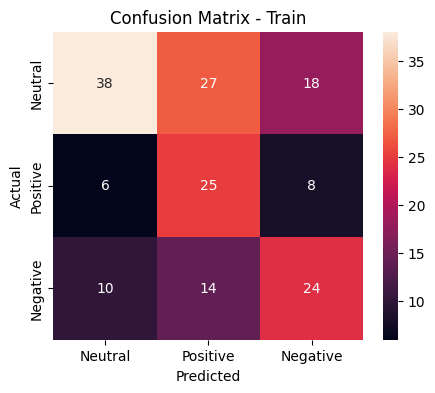

In [ ]:
plot_confusion_matrix(y_train, y_train_pred, title="Confusion Matrix - Train")

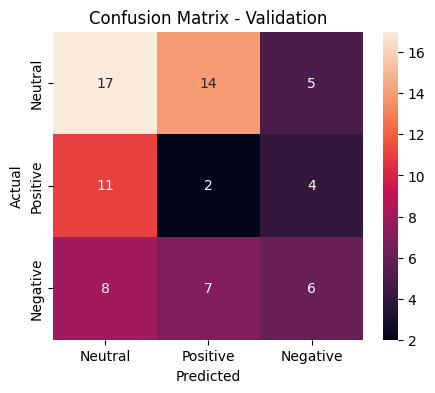

In [ ]:
plot_confusion_matrix(y_val, y_val_pred, title="Confusion Matrix - Validation")

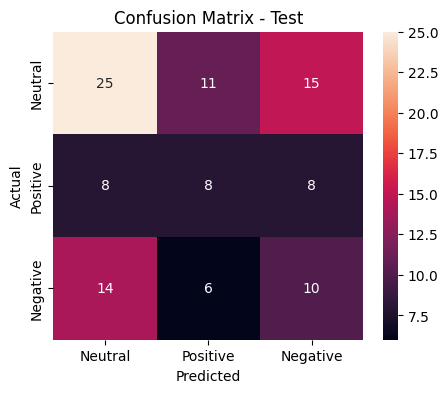

In [ ]:
plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix - Test")

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.70      0.46      0.55        83
           1       0.38      0.64      0.48        39
           2       0.48      0.50      0.49        48

    accuracy                           0.51       170
   macro avg       0.52      0.53      0.51       170
weighted avg       0.57      0.51      0.52       170



In [ ]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.47      0.47      0.47        36
           1       0.09      0.12      0.10        17
           2       0.40      0.29      0.33        21

    accuracy                           0.34        74
   macro avg       0.32      0.29      0.30        74
weighted avg       0.36      0.34      0.35        74



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51        51
           1       0.32      0.33      0.33        24
           2       0.30      0.33      0.32        30

    accuracy                           0.41       105
   macro avg       0.38      0.39      0.38       105
weighted avg       0.42      0.41      0.41       105



* The tuned SVM model has 51% accuracy on training data, 34% accuracy in validation data and 41% accuracy in the test dataset.

### Sentiment Analysis with GloVe embedding

#### Support Vector Machine (SVM)
We will start with SVM model for the GloVe embedding

In [ ]:
# data splitting
X = df_glove
y = data['Label']
# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((195, 100), (84, 100), (70, 100))

In [ ]:
# target variable remapping
y_train = y_train.map({0:0, 1:1, -1:2})
y_val = y_val.map({0:0, 1:1, -1:2})
y_test = y_test.map({0:0, 1:1, -1:2})

In [ ]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(Label
 0    95
 2    55
 1    45
 Name: count, dtype: int64,
 Label
 0    41
 2    24
 1    19
 Name: count, dtype: int64,
 Label
 0    34
 2    20
 1    16
 Name: count, dtype: int64)

In [ ]:
class_weight = compute_class_weight(class_weight='balanced', y = y_train, classes=np.unique(y_train))
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 0.6842105263157895, 1: 1.4444444444444444, 2: 1.1818181818181819}

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
svm_glove = SVC(class_weight=class_weight,random_state=42, decision_function_shape='ovo')
svm_glove.fit(X_train_scaled, y_train)

SVC(class_weight={0: 0.6842105263157895, 1: 1.4444444444444444,
                  2: 1.1818181818181819},
    decision_function_shape='ovo', random_state=42)

In [ ]:
y_train_pred = svm_glove.predict(X_train_scaled)
y_val_pred = svm_glove.predict(X_val_scaled)
y_test_pred = svm_glove.predict(X_test_scaled)

In [ ]:
df_models = pd.concat([df_models,
                       pd.DataFrame({
                           'train':[accuracy_score(y_train, y_train_pred)],
                           'validation':[accuracy_score(y_val, y_val_pred)],
                           'test': [accuracy_score(y_test, y_test_pred)]}, index = ['GloVe_SVM'])])
df_models

train  validation      test
RF_W2V         1.000000    0.491803  0.447619
RF_W2V_Tuned   0.614754    0.323770  0.447619
W2V_SVM        0.682353    0.391892  0.438095
W2V_SVM_Tuned  0.511765    0.337838  0.409524
GloVe_SVM      0.810256    0.357143  0.385714

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.69      0.81        95
           1       0.70      0.93      0.80        45
           2       0.74      0.91      0.81        55

    accuracy                           0.81       195
   macro avg       0.81      0.85      0.81       195
weighted avg       0.85      0.81      0.81       195



In [ ]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.52      0.39      0.44        41
           1       0.22      0.26      0.24        19
           2       0.30      0.38      0.33        24

    accuracy                           0.36        84
   macro avg       0.34      0.34      0.34        84
weighted avg       0.39      0.36      0.37        84



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.48      0.38      0.43        34
           1       0.26      0.38      0.31        16
           2       0.40      0.40      0.40        20

    accuracy                           0.39        70
   macro avg       0.38      0.39      0.38        70
weighted avg       0.41      0.39      0.39        70



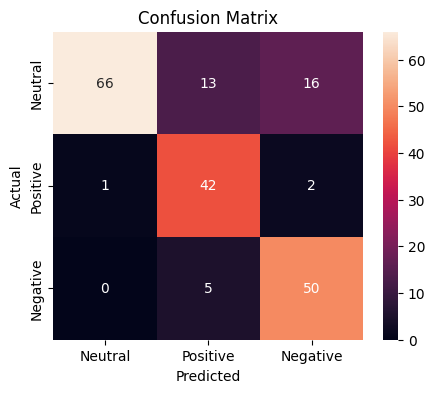

In [ ]:
plot_confusion_matrix(y_train, y_train_pred)

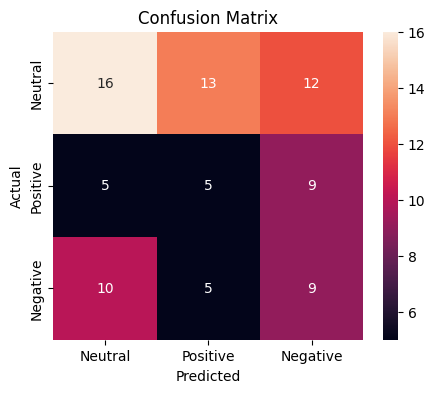

In [ ]:
plot_confusion_matrix(y_val, y_val_pred)

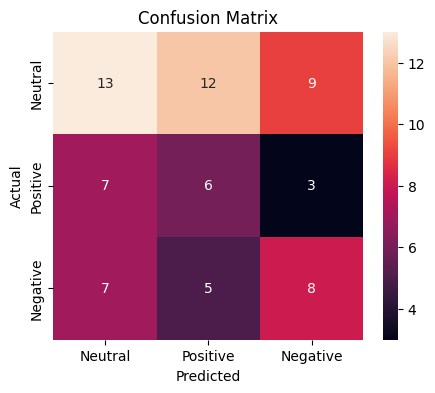

In [ ]:
plot_confusion_matrix(y_test, y_test_pred)

* The model achieves 81% accuracy in training set, but only 36% accuracy in validation set and 39% accuracy in the test set. The model overfits. We will try to tune the hyper-parameters next to reduce the overfitting.

In [ ]:
svm_model = SVC(class_weight=class_weight,random_state=42, decision_function_shape='ovo')
param_dist = {
     # lower value will reduce overfitting
    'C': np.logspace(-2, -1, 7),
     # used in non-linear kernel, lower value will reduce overfitting
    'gamma': np.logspace(-3, 1, 10),
    'kernel': ['linear','rbf','poly', 'sigmoid']
}
# Train the model with RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train_scaled, y_train)
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'kernel': 'linear', 'gamma': 0.001, 'C': 0.09999999999999999}
Best Accuracy: 0.4153846153846154


In [ ]:
best_model.fit(X_train_scaled, y_train)


SVC(C=0.09999999999999999,
    class_weight={0: 0.6842105263157895, 1: 1.4444444444444444,
                  2: 1.1818181818181819},
    decision_function_shape='ovo', gamma=0.001, kernel='linear',
    random_state=42)

In [ ]:
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)
y_test_pred = best_model.predict(X_test_scaled)

In [ ]:
df_models= pd.concat([df_models,
                      pd.DataFrame({
    'train':[accuracy_score(y_train, y_train_pred)],
    'validation':[accuracy_score(y_val, y_val_pred)],
    'test': [accuracy_score(y_test, y_test_pred)]}, index = ['GloVe_SVM_Tuned'])])
df_models

train  validation      test
RF_W2V           1.000000    0.491803  0.447619
RF_W2V_Tuned     0.614754    0.323770  0.447619
W2V_SVM          0.682353    0.391892  0.438095
W2V_SVM_Tuned    0.511765    0.337838  0.409524
GloVe_SVM        0.810256    0.357143  0.385714
GloVe_SVM_Tuned  0.584615    0.416667  0.400000

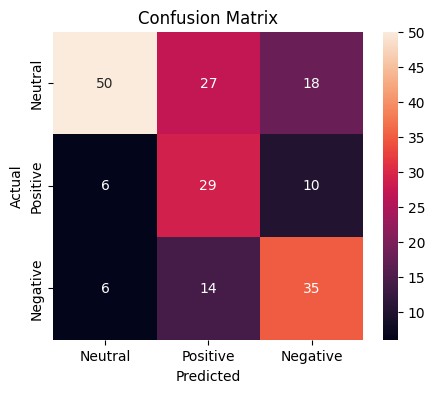

In [ ]:
plot_confusion_matrix(y_train, y_train_pred)

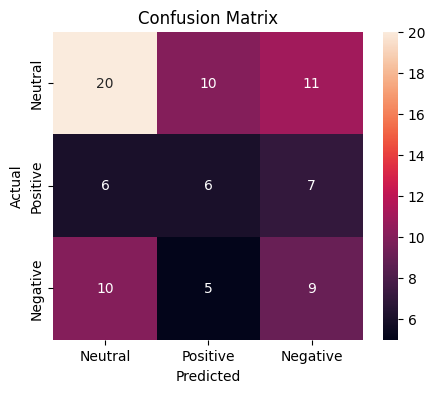

In [ ]:
plot_confusion_matrix(y_val, y_val_pred)

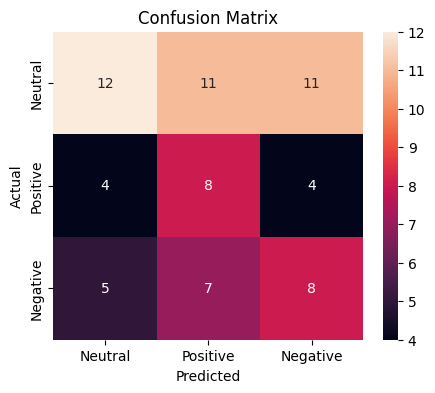

In [ ]:
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.81      0.53      0.64        95
           1       0.41      0.64      0.50        45
           2       0.56      0.64      0.59        55

    accuracy                           0.58       195
   macro avg       0.59      0.60      0.58       195
weighted avg       0.65      0.58      0.59       195



In [ ]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.56      0.49      0.52        41
           1       0.29      0.32      0.30        19
           2       0.33      0.38      0.35        24

    accuracy                           0.42        84
   macro avg       0.39      0.39      0.39        84
weighted avg       0.43      0.42      0.42        84



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.57      0.35      0.44        34
           1       0.31      0.50      0.38        16
           2       0.35      0.40      0.37        20

    accuracy                           0.40        70
   macro avg       0.41      0.42      0.40        70
weighted avg       0.45      0.40      0.41        70



* After tuning hyper parameter of svm we get 58% accuracy in training data, 42% accuracy in validation data and 40% accuracy in test data. We will try using RandomForest next.

#### RandomForest
As our dataset is small we will set `oob_score` true for validation and only use train and test split.

In [ ]:
# data splitting
X = df_glove
y = data['Label']
# Data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape

((244, 100), (105, 100))

In [ ]:
y_train = y_train.map({0:0, 1:1, -1:2})
y_test = y_test.map({0:0, 1:1, -1:2})

In [ ]:
y_train.value_counts(), y_test.value_counts()

(Label
 0    119
 2     69
 1     56
 Name: count, dtype: int64,
 Label
 0    51
 2    30
 1    24
 Name: count, dtype: int64)

In [ ]:
class_weight = compute_class_weight(class_weight='balanced', y = y_train, classes=np.unique(y_train))
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 0.6834733893557423, 1: 1.4523809523809523, 2: 1.178743961352657}

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
rf_glove = RandomForestClassifier(random_state=42, class_weight=class_weight, n_jobs=-1, oob_score=True, bootstrap=True)
rf_glove.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 0.6834733893557423,
                                     1: 1.4523809523809523,
                                     2: 1.178743961352657},
                       n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
y_train_pred = rf_glove.predict(X_train_scaled)
y_test_pred = rf_glove.predict(X_test_scaled)

In [ ]:
df_models = pd.concat([ df_models,
    pd.DataFrame({'train':[accuracy_score(y_train, y_train_pred)], 'validation':[rf_glove.oob_score_], 'test': [accuracy_score(y_test, y_test_pred)]}, index = ['GloVe_RF'])])
df_models

train  validation      test
RF_W2V           1.000000    0.491803  0.447619
RF_W2V_Tuned     0.614754    0.323770  0.447619
W2V_SVM          0.682353    0.391892  0.438095
W2V_SVM_Tuned    0.511765    0.337838  0.409524
GloVe_SVM        0.810256    0.357143  0.385714
GloVe_SVM_Tuned  0.584615    0.416667  0.400000
GloVe_RF         1.000000    0.454918  0.438095

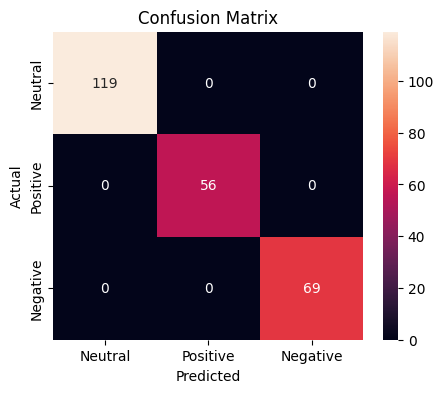

In [ ]:
plot_confusion_matrix(y_train, y_train_pred)

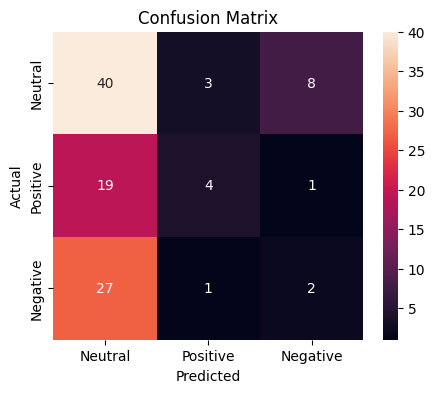

In [ ]:
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        69

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.47      0.78      0.58        51
           1       0.50      0.17      0.25        24
           2       0.18      0.07      0.10        30

    accuracy                           0.44       105
   macro avg       0.38      0.34      0.31       105
weighted avg       0.39      0.44      0.37       105



* The RandomForest model gives us 100% accuracy in training data, 45% estimated validation accuracy and 44% accuracy in test data.
* We will tune hyper parameter of this model to reduce overfitting

In [ ]:
params = {
    'n_estimators': [30,40,50],
    'max_depth': [1,2,3],
    'min_samples_split': [3,4,5],
    'criterion': ['gini','entropy'],
    'min_samples_leaf': [17,19,20],
    'ccp_alpha':[0.08],
    'oob_score':[True],
    'bootstrap':[True]
}
rf_glove = RandomForestClassifier(random_state=42, class_weight=class_weight, n_jobs=-1, oob_score=True, bootstrap=True)
random_search = RandomizedSearchCV(
    n_iter = 30,
    estimator = rf_glove,
    param_distributions=params,
    cv=5,
    random_state=42,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1

)
random_search.fit(X_train_scaled, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'oob_score': True, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 19, 'max_depth': 1, 'criterion': 'entropy', 'ccp_alpha': 0.08, 'bootstrap': True}
Best Accuracy: 0.4054421768707483


In [ ]:
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

In [ ]:
df_models = pd.concat([df_models,
    pd.DataFrame({
    'train':[accuracy_score(y_train, y_train_pred)],
    'validation':[best_model.oob_score_],
    'test': [accuracy_score(y_test, y_test_pred)]}, index = ['GloVe_RF_Tuned'])])

In [ ]:
df_models

train  validation      test
RF_W2V           1.000000    0.491803  0.447619
RF_W2V_Tuned     0.614754    0.323770  0.447619
W2V_SVM          0.682353    0.391892  0.438095
W2V_SVM_Tuned    0.511765    0.337838  0.409524
GloVe_SVM        0.810256    0.357143  0.385714
GloVe_SVM_Tuned  0.584615    0.416667  0.400000
GloVe_RF         1.000000    0.454918  0.438095
GloVe_RF_Tuned   0.463115    0.295082  0.323810

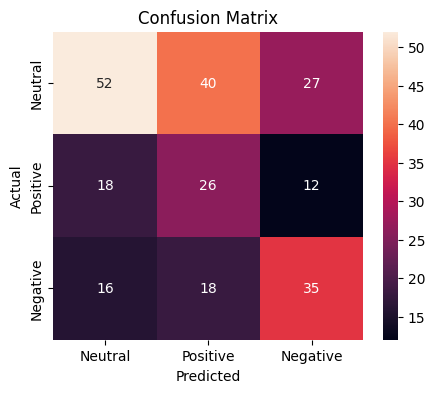

In [ ]:
plot_confusion_matrix(y_train, y_train_pred)

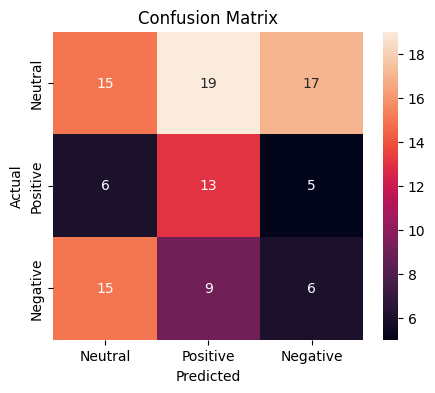

In [ ]:
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.60      0.44      0.51       119
           1       0.31      0.46      0.37        56
           2       0.47      0.51      0.49        69

    accuracy                           0.46       244
   macro avg       0.46      0.47      0.46       244
weighted avg       0.50      0.46      0.47       244



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.42      0.29      0.34        51
           1       0.32      0.54      0.40        24
           2       0.21      0.20      0.21        30

    accuracy                           0.32       105
   macro avg       0.32      0.35      0.32       105
weighted avg       0.34      0.32      0.32       105



* We observe that after tuning the hyper parameter of RandomForest model, we get 46% accuracy in training set and 32% accuracy in the test set. The accuracy score is not satisfactory.

### Sentiment analysis with SentenceTransformer embedding

#### RandomForest
* We will set `oob_score` true and use it for estimated validation score.

In [ ]:
# data split
X = np.load('/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/sentence_embeddings.npy')
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
X_train.shape, X_test.shape

((244, 384), (105, 384))

In [ ]:
# target variable remapping
y_train = y_train.map({0:0, 1:1, -1:2})
y_test = y_test.map({0:0, 1:1, -1:2})

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
class_weight = compute_class_weight(class_weight='balanced', y = y_train, classes=np.unique(y_train))
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 0.6834733893557423, 1: 1.4523809523809523, 2: 1.178743961352657}

In [ ]:
rf_sent = RandomForestClassifier(random_state=42, class_weight=class_weight, n_jobs=-1, oob_score=True, bootstrap=True)
rf_sent.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 0.6834733893557423,
                                     1: 1.4523809523809523,
                                     2: 1.178743961352657},
                       n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
y_train_pred = rf_sent.predict(X_train_scaled)
y_test_pred = rf_sent.predict(X_test_scaled)

In [ ]:
df_models = pd.concat([ df_models,
    pd.DataFrame({'train':[accuracy_score(y_train, y_train_pred)], 'validation':[rf_sent.oob_score_], 'test': [accuracy_score(y_test, y_test_pred)]}, index = ['Sent_RF'])])
df_models

train  validation      test
RF_W2V           1.000000    0.491803  0.447619
RF_W2V_Tuned     0.614754    0.323770  0.447619
W2V_SVM          0.682353    0.391892  0.438095
W2V_SVM_Tuned    0.511765    0.337838  0.409524
GloVe_SVM        0.810256    0.357143  0.385714
GloVe_SVM_Tuned  0.584615    0.416667  0.400000
GloVe_RF         1.000000    0.454918  0.438095
GloVe_RF_Tuned   0.463115    0.295082  0.323810
Sent_RF          1.000000    0.520492  0.466667

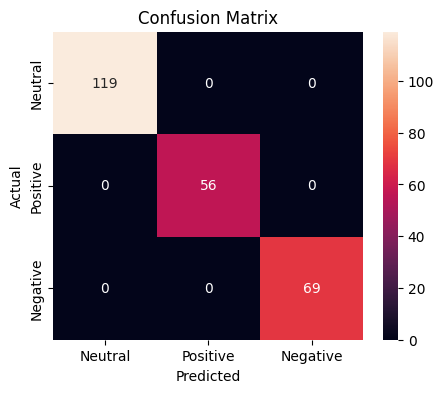

In [ ]:
plot_confusion_matrix(y_train, y_train_pred)

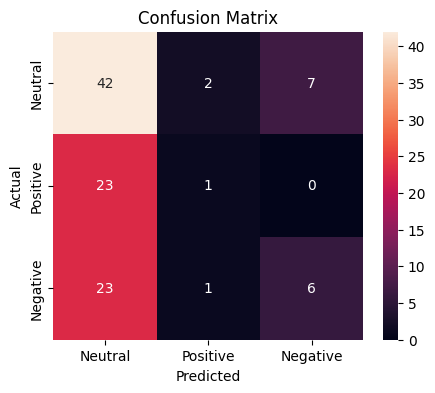

In [ ]:
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       1.00      1.00      1.00        56
           2       1.00      1.00      1.00        69

    accuracy                           1.00       244
   macro avg       1.00      1.00      1.00       244
weighted avg       1.00      1.00      1.00       244



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.48      0.82      0.60        51
           1       0.25      0.04      0.07        24
           2       0.46      0.20      0.28        30

    accuracy                           0.47       105
   macro avg       0.40      0.36      0.32       105
weighted avg       0.42      0.47      0.39       105



* We observe RandomForest model overfits with 100% accuracy in training set, 52% validation score and 47% accuracy in test set. We tune the hyper parameters to reduce overfitting.

In [ ]:
params = {
    'n_estimators': [20,30,40],
    'max_depth': [2,3,4],
    'min_samples_split': [17,18,19],
    'min_samples_leaf': [20,21,22],
    'oob_score':[True],
    'bootstrap':[True],
    'criterion': ['gini','entropy'],
    'ccp_alpha':[0.09,0.15,0.2]
}
rf_sent = RandomForestClassifier(random_state=42, class_weight=class_weight, n_jobs=-1, oob_score=True, bootstrap=True)
random_search = RandomizedSearchCV(
    n_iter = 30,
    estimator = rf_sent,
    param_distributions=params,
    cv=5,
    random_state=42,
    scoring='accuracy'
)
random_search.fit(X_train_scaled, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)
best_model = random_search.best_estimator_

Best Parameters: {'oob_score': True, 'n_estimators': 20, 'min_samples_split': 18, 'min_samples_leaf': 20, 'max_depth': 2, 'criterion': 'entropy', 'ccp_alpha': 0.09, 'bootstrap': True}
Best Accuracy: 0.4962585034013605


In [ ]:
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)

In [ ]:
df_models = pd.concat([df_models,
pd.DataFrame({'train':[accuracy_score(y_train, y_train_pred)],
              'validation':[best_model.oob_score_],
              'test': [accuracy_score(y_test, y_test_pred)]}, index = ['Sent_RF_Tuned'])])
df_models

train  validation      test
RF_W2V           1.000000    0.491803  0.447619
RF_W2V_Tuned     0.614754    0.323770  0.447619
W2V_SVM          0.682353    0.391892  0.438095
W2V_SVM_Tuned    0.511765    0.337838  0.409524
GloVe_SVM        0.810256    0.357143  0.385714
GloVe_SVM_Tuned  0.584615    0.416667  0.400000
GloVe_RF         1.000000    0.454918  0.438095
GloVe_RF_Tuned   0.463115    0.295082  0.323810
Sent_RF          1.000000    0.520492  0.466667
Sent_RF_Tuned    0.680328    0.422131  0.400000

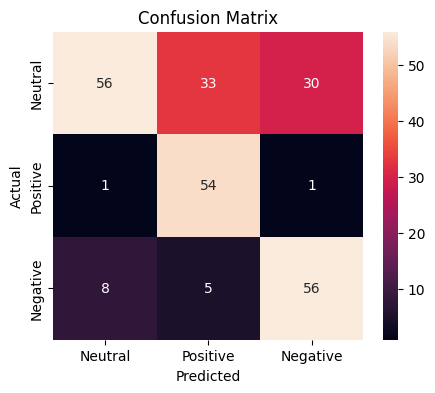

In [ ]:
plot_confusion_matrix(y_train, y_train_pred)

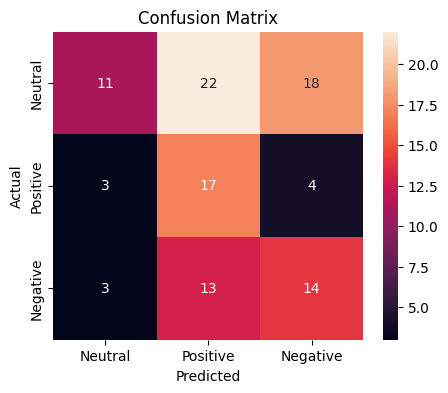

In [ ]:
plot_confusion_matrix(y_test, y_test_pred)

* After tuning the hyper parameter we achieved 68% accuracy in the training set, 42% accuracy in the validation set and 40% accuracy in the test set. The model didn't generalize very well.

#### Support Vector Machine (SVM)

In [ ]:
# data split
X = np.load('/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/sentence_embeddings.npy')
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((195, 384), (49, 384), (105, 384))

In [ ]:
y_train = y_train.map({0:0, 1:1, -1:2})
y_val = y_val.map({0:0, 1:1, -1:2})
y_test = y_test.map({0:0, 1:1, -1:2})

In [ ]:
y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(Label
 0    95
 2    55
 1    45
 Name: count, dtype: int64,
 Label
 0    24
 2    14
 1    11
 Name: count, dtype: int64,
 Label
 0    51
 2    30
 1    24
 Name: count, dtype: int64)

In [ ]:
class_weight = compute_class_weight(class_weight='balanced', y = y_train, classes=np.unique(y_train))
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 0.6842105263157895, 1: 1.4444444444444444, 2: 1.1818181818181819}

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
svm_model = SVC(class_weight=class_weight,random_state=42, decision_function_shape='ovo')
svm_model.fit(X_train_scaled, y_train)

SVC(class_weight={0: 0.6842105263157895, 1: 1.4444444444444444,
                  2: 1.1818181818181819},
    decision_function_shape='ovo', random_state=42)

In [ ]:
y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

In [ ]:
df_models = pd.concat([df_models,
pd.DataFrame({
    'train': accuracy_score(y_train, y_train_pred),
    'validation':accuracy_score(y_val, y_val_pred),
    'test': accuracy_score(y_test, y_test_pred)}, index = ['Sent_SVM'])])

In [ ]:
df_models

train  validation      test
RF_W2V           1.000000    0.491803  0.447619
RF_W2V_Tuned     0.614754    0.323770  0.447619
W2V_SVM          0.682353    0.391892  0.438095
W2V_SVM_Tuned    0.511765    0.337838  0.409524
GloVe_SVM        0.810256    0.357143  0.385714
GloVe_SVM_Tuned  0.584615    0.416667  0.400000
GloVe_RF         1.000000    0.454918  0.438095
GloVe_RF_Tuned   0.463115    0.295082  0.323810
Sent_RF          1.000000    0.520492  0.466667
Sent_RF_Tuned    0.680328    0.422131  0.400000
Sent_SVM         0.953846    0.469388  0.438095

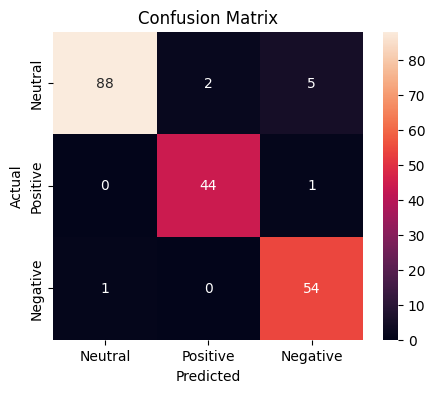

In [ ]:
plot_confusion_matrix(y_train, y_train_pred)

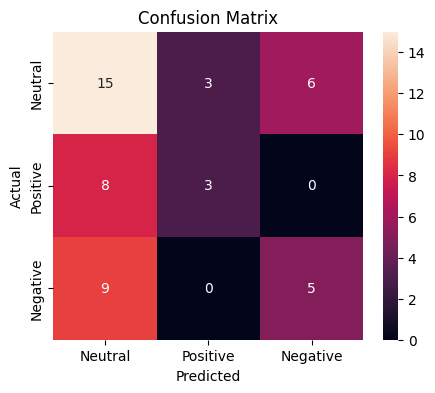

In [ ]:
plot_confusion_matrix(y_val, y_val_pred)

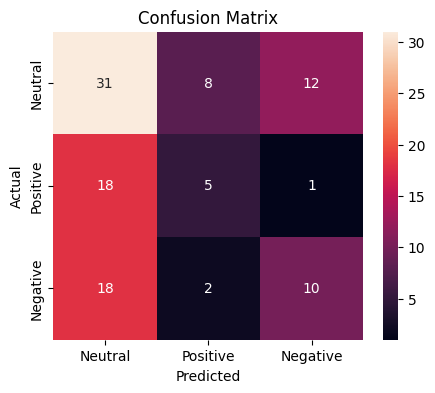

In [ ]:
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96        95
           1       0.96      0.98      0.97        45
           2       0.90      0.98      0.94        55

    accuracy                           0.95       195
   macro avg       0.95      0.96      0.95       195
weighted avg       0.96      0.95      0.95       195



In [ ]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.47      0.62      0.54        24
           1       0.50      0.27      0.35        11
           2       0.45      0.36      0.40        14

    accuracy                           0.47        49
   macro avg       0.47      0.42      0.43        49
weighted avg       0.47      0.47      0.46        49



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.46      0.61      0.53        51
           1       0.33      0.21      0.26        24
           2       0.43      0.33      0.38        30

    accuracy                           0.44       105
   macro avg       0.41      0.38      0.39       105
weighted avg       0.43      0.44      0.42       105



* The SVM model using sentence transformer embedding achieves 95% accuracy in training set, 47% accuracy in the validation set and 44% accuracy in the test set. This model overfits. We will tune hyper parameter to reduce the overfitting.

In [ ]:
svm_model = SVC(class_weight=class_weight,random_state=42, decision_function_shape='ovo')
param_dist = {
    'C': np.logspace(-4, -2, 10),  # Regularization parameter
    'gamma': np.logspace(-3, 1, 10),  # Kernel coefficient
    'kernel': ['linear', 'rbf']  # Different kernel functions
}
# Train the model with RandomizedSearchCV
random_search = RandomizedSearchCV(
    svm_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)
random_search.fit(X_train_scaled, y_train)
svm_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'kernel': 'linear', 'gamma': 0.002782559402207126, 'C': 0.000774263682681127}
Best Accuracy: 0.5435897435897435


In [ ]:
svm_model.fit(X_train_scaled, y_train)

SVC(C=0.000774263682681127,
    class_weight={0: 0.6842105263157895, 1: 1.4444444444444444,
                  2: 1.1818181818181819},
    decision_function_shape='ovo', gamma=0.002782559402207126, kernel='linear',
    random_state=42)

In [ ]:
y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

In [ ]:
df_models = pd.concat([df_models,
pd.DataFrame({
    'train':[accuracy_score(y_train, y_train_pred)],
    'validation':[accuracy_score(y_val, y_val_pred)],
    'test':[accuracy_score(y_test, y_test_pred)]}, index = ['Sent_SVM_Tuned'])])
df_models

train  validation      test
RF_W2V           1.000000    0.491803  0.447619
RF_W2V_Tuned     0.614754    0.323770  0.447619
W2V_SVM          0.682353    0.391892  0.438095
W2V_SVM_Tuned    0.511765    0.337838  0.409524
GloVe_SVM        0.810256    0.357143  0.385714
GloVe_SVM_Tuned  0.584615    0.416667  0.400000
GloVe_RF         1.000000    0.454918  0.438095
GloVe_RF_Tuned   0.463115    0.295082  0.323810
Sent_RF          1.000000    0.520492  0.466667
Sent_RF_Tuned    0.680328    0.422131  0.400000
Sent_SVM         0.953846    0.469388  0.438095
Sent_SVM_Tuned   0.728205    0.612245  0.447619

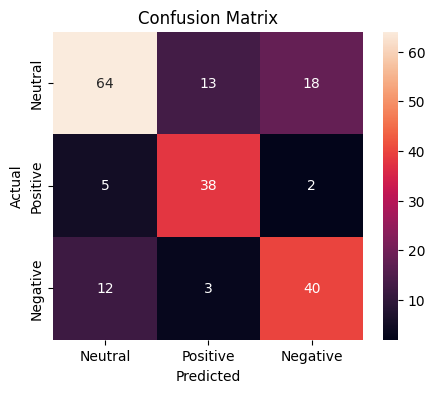

In [ ]:
plot_confusion_matrix(y_train, y_train_pred)

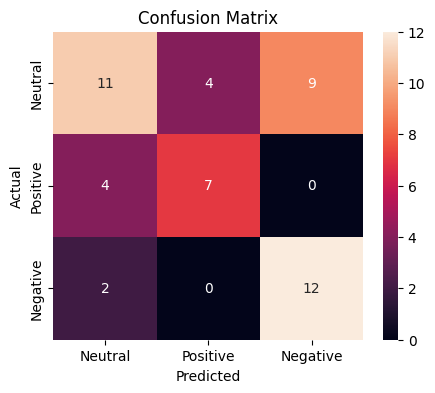

In [ ]:
plot_confusion_matrix(y_val, y_val_pred)

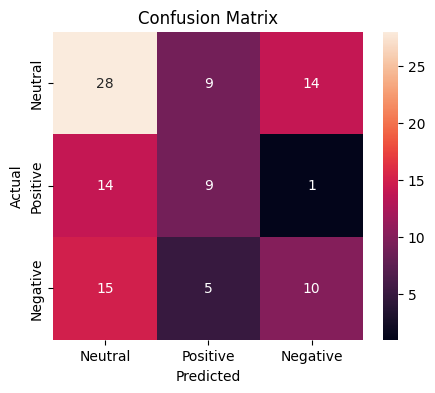

In [ ]:
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.79      0.67      0.73        95
           1       0.70      0.84      0.77        45
           2       0.67      0.73      0.70        55

    accuracy                           0.73       195
   macro avg       0.72      0.75      0.73       195
weighted avg       0.74      0.73      0.73       195



In [ ]:
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.65      0.46      0.54        24
           1       0.64      0.64      0.64        11
           2       0.57      0.86      0.69        14

    accuracy                           0.61        49
   macro avg       0.62      0.65      0.62        49
weighted avg       0.62      0.61      0.60        49



In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.49      0.55      0.52        51
           1       0.39      0.38      0.38        24
           2       0.40      0.33      0.36        30

    accuracy                           0.45       105
   macro avg       0.43      0.42      0.42       105
weighted avg       0.44      0.45      0.44       105



* The tuned SVM model achives 73% accuracy in the training data, 54% accuracy in the validation data and 45% accuracy in the test data.

### Final Model selection

In [ ]:
df_models

train  validation      test
RF_W2V           1.000000    0.491803  0.447619
RF_W2V_Tuned     0.614754    0.323770  0.447619
W2V_SVM          0.682353    0.391892  0.438095
W2V_SVM_Tuned    0.511765    0.337838  0.409524
GloVe_SVM        0.810256    0.357143  0.385714
GloVe_SVM_Tuned  0.584615    0.416667  0.400000
GloVe_RF         1.000000    0.454918  0.438095
GloVe_RF_Tuned   0.463115    0.295082  0.323810
Sent_RF          1.000000    0.520492  0.466667
Sent_RF_Tuned    0.680328    0.422131  0.400000
Sent_SVM         0.953846    0.469388  0.438095
Sent_SVM_Tuned   0.728205    0.612245  0.447619

* We built 12 models for sentiment analysis using RandomForest classifier and Support Vector Machine (SVM) classifier. The above table shows the accuracy score of each model against training, validation and test dataset.
* All our base models aggresively overfit with around 100% accuracy in training data set.
* Among the tuned models, RandomForest model(`RF_W2V_Tuned`) using Word2Vector embeddings achieves the highest 44.7% accuracy in the test dataset. The tuned Support Vector Machine(SVM) model using Sentence Transformer emebeddings also achieves 44.7% accuracy in the test dataset.
* The tuned SVM model(`Sent_SVM_Tuned`) using Sentence Transformer embedding scores around 72% accuracy in training dataset and 61% accuracy in the validation dataset.
* The tuned RandomForest model(`RF_W2V_Tuned`) using Word2Vec embdedding, however, achieves slightly lower accuracy in training dataset, around 61%. It scores only 32% accuracy against the validation dataset.
* So, the tuned SVM model(`Sent_SVM_Tuned`) has the best performance against the training, validation and test dataset. This model still overfits, however, it generalizes better than any other models we tried. The overfitting could be due to small dataset.
* For the above reason our chosen model is the tuned SVM model(`Sent_SVM_Tuned`) using SentenceTransformer embedding.

#### Chosen model performance

In [ ]:
y_test_pred = svm_model.predict(X_test_scaled)
accuracy_score(y_test, y_test_pred)

0.44761904761904764

In [ ]:
df_models.iloc[11:]

train  validation      test
Sent_SVM_Tuned  0.728205    0.612245  0.447619

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 --force-reinstall --upgrade --no-cache-dir

In [6]:
# import libraries for llm models
import torch
from llama_cpp import Llama
from huggingface_hub import hf_hub_download
# Importing the library for data manipulation
import pandas as pd
import numpy as np
# For progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

#### Loading the model

In [7]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin" # the model is in bin format

# Download the model to the /content folder in Colab
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)
print(f"Model downloaded to: {model_path}")

Using device: cuda


llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGML/snapshots/3140827b4dfcb6b562cd87ee3d7f07109b014dd0/llama-2-13b-chat.ggmlv3.q5_1.bin


In [8]:
# Load the model with T4-optimized settings
llama_model = Llama(
    model_path=model_path,
    n_threads=2,
    n_gpu_layers=41,
    n_batch=512,
    n_ctx=4096
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


#### Aggregating the data weekly

In [9]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [10]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [11]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with '||' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [12]:
pd.set_option('display.max_colwidth', None)

In [13]:
weekly_grouped.head(1)

Date  \
0 2019-01-06   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [72]:
# creating a copy of the data
weekly_data = weekly_grouped.copy()

In [73]:
token_count = weekly_data['News'].apply(lambda text: len(llama_model.tokenize(text.encode("utf-8"), add_bos=True)))
print("Max token count:", max(token_count))

Max token count: 4037


* We observe that the maximum input token count for a single news article could be 4037. The context length supported by Llama 2 model is 4096. The context length includes both input and output tokens. The model stops generating token when it reaches context length. We have to address this carefully.

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

##### Utility Functions

In [9]:
import json
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        print(f"Input string: {json_str}")
        return {}

##### Defining the response function

In [10]:
#Defining the response function
def response_llm(prompt):
    model_output = llama_model(
      prompt,
      max_tokens=2048,
      temperature=0.1,
      top_p=0.95,
      top_k=50,
      repeat_penalty=1.2,
      stop=['INST'],
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Prompt template

In [11]:
def generate_prompt(news, instructions = ""):
  if instructions == "":
    instructions = f"""
    You are a news analyst specialized in analysing stock market news.

    You will:
      - classify the sentiment of the news article either postive or negative. Classify the news positive if it has positive impact on the stock price. Classify the news negative if it has negative impact on the stock price.
      - Rate the news from -10 (most negative) to +10 (most positive)
      - format the result in JSON format as below:
      {{
        "news" : "{news}",
        "sentiment":"predicted sentiment of the news",
        "sentiment_score": "number between -10 and 10",
      }}
    """

  prompt = """
  {news}

  [INST]<<SYS>>
    {instructions}
  <</SYS>>[/INST]
  """.format(news=news, instructions=instructions)
  return prompt

##### Checking the model output on a sample

In [125]:
weekly_news_articles = weekly_data["News"][0].split("||")
test_prompt_1 = generate_prompt(weekly_news_articles[0])
print(test_prompt_1)


   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January. 

  [INST]<<SYS>>
    
    You are a news analyst specialized in analysing stock market news.
  
    You will:
      - classify the sentiment of the news article either postive or negative. Classify the news positive if it has positive impact on the stock price. Classify the news negative if it has negative impact on the stock price.
      - Rate the news from -10 (most negative) to +10 (most positive)
      - format the result in JSON format as below:
      {
        "news" : " The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw t

In [126]:
# checking the prompt and llm result
for i in range(3):
  prompt = generate_prompt(weekly_news_articles[i])
  print(prompt)
  llm_response = response_llm(prompt)
  print(extract_json_data(llm_response))


   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January. 

  [INST]<<SYS>>
    
    You are a news analyst specialized in analysing stock market news.
  
    You will:
      - classify the sentiment of the news article either postive or negative. Classify the news positive if it has positive impact on the stock price. Classify the news negative if it has negative impact on the stock price.
      - Rate the news from -10 (most negative) to +10 (most positive)
      - format the result in JSON format as below:
      {
        "news" : " The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw t

Llama.generate: prefix-match hit


{'news': "The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.", 'sentiment': 'Negative', 'sentiment_score': -8}

    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 

  [INST]<<SYS>>
    
    You are a news analyst specialized in analysing stock market news.
  
    You will:
      - classify the sentiment of the news article either postive or negative. Classify the news positive if it has positive impact on the stock price. Classify the news negativ

Llama.generate: prefix-match hit


{'news': "Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10", 'sentiment': 'Negative', 'sentiment_score': -8}

    Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon 

  [INST]<<SYS>>
    
    You are a news analyst specialized in analysing stock market news.
  
    You will:
      - classify the sentiment of the news article either postive or negative. Classify the news positive if it has positive impact on the stock price. Classify the news negative if it has negative impact 

Llama.generate: prefix-match hit


{'news': "Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon ", 'sentiment': 'Negative', 'sentiment_score': -7}


* We observe that the model generates same rating for multiple news, so sentiment_score is not going to help us identify top 3 positive and negative news as more than 3 news might have same rating.
* We optimize our prompt and exclude sentiment rating. Once we identify postive and negative sentiment for all news, we can ask the model to identify top 3 positive events from the list of positive news and top 3 negative events from the list of negative news.

In [127]:
def generate_sent_analysis_prompt(news):
  instructions = f"""
    You are a news analyst specialized in analysing stock market news.

    You will:
      - classify the sentiment of the news article either postive or negative. Classify the news positive if it has positive impact on the stock price. Classify the news negative if it has negative impact on the stock price.
      - format the result in JSON format as below:
      {{
        "news" : "{news}",
        "sentiment":"predicted sentiment of the news"
      }}
    """
  return generate_prompt(news, instructions)

In [129]:
# checking the prompt and llm result
for i in range(3):
  prompt = generate_sent_analysis_prompt(weekly_news_articles[i])
  print(prompt)
  llm_response = response_llm(prompt)
  print(extract_json_data(llm_response))


   The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January. 

  [INST]<<SYS>>
    
    You are a news analyst specialized in analysing stock market news.
  
    You will:
      - classify the sentiment of the news article either postive or negative. Classify the news positive if it has positive impact on the stock price. Classify the news negative if it has negative impact on the stock price.
      - format the result in JSON format as below:
      {
        "news" : " The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its reven

Llama.generate: prefix-match hit


{'news': "The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.", 'sentiment': 'Negative'}

    Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 

  [INST]<<SYS>>
    
    You are a news analyst specialized in analysing stock market news.
  
    You will:
      - classify the sentiment of the news article either postive or negative. Classify the news positive if it has positive impact on the stock price. Classify the news negative if it has negative im

Llama.generate: prefix-match hit


{'news': "Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10", 'sentiment': 'Negative'}

    Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon 

  [INST]<<SYS>>
    
    You are a news analyst specialized in analysing stock market news.
  
    You will:
      - classify the sentiment of the news article either postive or negative. Classify the news positive if it has positive impact on the stock price. Classify the news negative if it has negative impact on the stock price.
   

Llama.generate: prefix-match hit


{'news': "Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon ", 'sentiment': 'Negative'}


##### Checking the model output on the weekly data

In [130]:
# array of news per week
weekly_news_articles = [weekly_data["News"][i].split("||") for i in range(weekly_data.shape[0])]

In [ ]:
# iterate through each news by week and classify their sentiment
news_dict = {}
for i in range(weekly_data.shape[0]):
  weekly_date = weekly_data["Date"][i].strftime("%Y-%m-%d")
  if weekly_date not in news_dict:
     news_dict[weekly_date] = {"positive_events": [], "negative_events": []}
  print(f"Processing  {len(weekly_news_articles[i])} news for week: {weekly_date}")
  for index, item in enumerate(weekly_news_articles[i]):
    print(f"Processing news index: {index}")
    prompt = generate_sent_analysis_prompt(item)
    json_response = extract_json_data(response_llm(prompt))
    if "sentiment" not in json_response:
      print("Warning: llama 2 failed to predict sentiment for this news:", item)
      continue
    if json_response['sentiment'].lower() == 'positive':
       news_dict[weekly_date]["positive_events"].append(json_response)
    elif json_response['sentiment'].lower() == 'negative':
      news_dict[weekly_date]["negative_events"].append(json_response)

# save the file so we don't have to run it from scratch every time
file_path = f"/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/llama_news_sentiment.json"
try:
  with open(file_path, "w") as f:
    json.dump(news_dict, f, indent=4)
  print(f"Dictionary saved at: {file_path}")
except Exception as e:
  print(f"Error saving JSON file: {e}")

# print output was used for debugging and deleted before saving the file as html

* We will prompt the Llama 2 model to pick top 3 positive event and top 3 negative event per week.

##### Identify Top 3 positive and Top 3 negative news for a week

In [12]:
top_pos_news_instructions = """
    You are a news analyst specialized in analysing stock market news.
    You will:
    - identify top 3 positive events from the list of positive news given in JSON format.
    - output only in the following JSON format:
      {
        "date": "date of the news",
        "positive_events" : [
         {
            "news": "top most positive news event"
         },
         {
            "news": "2nd most positive news event"
         },
         {
            "news": "3rd most positive news event"
         }
        ]
      }
    - not add extra text before or after the JSON.
    - not number the events (e.g., `1., 2., 3.`).

    """
top_neg_news_instructions = """
    You are a news analyst specialized in analysing stock market news.
    You will:
    - identify top 3 negative events from the list of negative news given in JSON format.
    - output only in the following JSON format:
      {
        "date": "date of the news",
        "negative_events" : [
         {
            "news": "top most negative news event"
         },
         {
            "news": "2nd most negative news event"
         },
         {
            "news": "3rd most negative news event"
         }
        ]
      }
    - not add extra text before or after the JSON.
    - not number the events (e.g., `1., 2., 3.`).

    """

In [13]:
# load saved file from disk
file_path = "/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/llama_news_sentiment.json"
try:
  with open(file_path, "r") as f:
    news_dict = json.load(f)
except Exception as e:
  print(f"Error loading JSON file: {e}")

In [14]:
# testing prompt only first week of negative news content
# Get the first key-value pair
key, value = next(iter(news_dict.items()))
neg_dict = {
    "date": key,
    "negative_events": [event["news"] for event in value["negative_events"]]
}
json_string = json.dumps(neg_dict, indent=4)
prompt  = generate_prompt(json_string, top_neg_news_instructions)
llm_response = response_llm(prompt)
extract_json_data(llm_response)

{'date': '2019-01-06',
 'negative_events': [{'news': "Apple cut its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10"},
  {'news': 'Apple lowered its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks.'},
  {'news': "Wall Street saw modest gains on Wednesday but were threatened by fears of a global economic slowdown following Apple's shocking revenue forecast cut, blaming weak demand in China. The tech giant's suppliers and S&P 500 futures also suffered losses."}]}

In [ ]:
# iterate through each weeks data and build the json for top 3 positive and negative news event
weekly_top_news = {}
for key, value in news_dict.items():
  print(f"Processing negative news for week: {key}")
  neg_dict = {
    "date": key,
    "negative_events": [event["news"] for event in value["negative_events"]]
  }
  json_string = json.dumps(neg_dict, indent=4)
  prompt  = generate_prompt(json_string, top_neg_news_instructions)
  llm_response =  extract_json_data(response_llm(prompt))
  if key not in weekly_top_news:
    weekly_top_news[key] =  {}
  weekly_top_news[key]["negative_events"] = llm_response.get("negative_events", [])
  print(f"Processing positive news for week: {key}")

  pos_dict = {
    "date": key,
    "positive_events": [event["news"] for event in value["positive_events"]]
  }
  json_string = json.dumps(pos_dict, indent=4)
  prompt  = generate_prompt(json_string, top_pos_news_instructions)
  llm_response =  extract_json_data(response_llm(prompt))
  weekly_top_news[key]["positive_events"] = llm_response.get("positive_events", [])

# save the file so we don't have to run it from scratch every time
file_path = f"/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/top_news.json"
try:
  with open(file_path, "w") as f:
    json.dump(weekly_top_news, f, indent=4)
  print(f"Dictionary saved at: {file_path}")
except Exception as e:
  print(f"Error saving JSON file: {e}")

# print output was for debugging purpose, and was deleted before converting to html

In [17]:
top_news_json = json.dumps(weekly_top_news, indent=4)
print(top_news_json)

{
    "2019-01-06": {
        "negative_events": [
            {
                "news": "Apple cut its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10"
            },
            {
                "news": "Apple lowered its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks."
            },
            {
                "news": "This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the p

In [58]:
len(llama_model.tokenize(top_news_json.encode("utf-8"), add_bos=True))

7287

* We will now prompt the llm to summarise the weekly events based on top 3 positive and top 3 negative events.

##### Summarise weekly news event

In [70]:
# load saved file from disk
file_path = "/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/top_news.json"
try:
  with open(file_path, "r") as f:
    weekly_top_news = json.load(f)
except Exception as e:
  print(f"Error loading JSON file: {e}")

In [75]:
def get_news_summary_instructions(date):
  return f"""
      You are a news analyst specialized in analysing stock market news.
      You will:
      - summarise the news of a week based on the news given to you in JSON format.
      - classify the overall sentiment for the week in following categories only:
          1. postive - if the overall sentiment of the week has positive impact on stock price.
          2. negative - if the overall sentiment of the week has negative impact on stock price.
          3. neutral - if the overall sentiment of the week has no impact or mixed impact on stock price.
      - output in Strict JSON Format (Follow This Exactly):
        {{
          "{date}":{{
            "summary": "summary of weekly news",
            "sentiment": "predicted sentiment"
          }}
        }}
      - ensure the output is valid JSON.
      - not add extra text before or after the JSON.
      - not number the events (e.g., `1., 2., 3.`).
      """

In [76]:
# checking the prompt with the first week data
key, value = next(iter(weekly_top_news.items()))
first_week_news = json.dumps({
    key: value
})
prompt = generate_prompt(first_week_news, get_news_summary_instructions(key))
print(prompt)


  {"2019-01-06": {"negative_events": [{"news": "Apple cut its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10"}, {"news": "Apple lowered its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks."}, {"news": "This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown."}], "positive_events": [{"news": "Oil prices rebounded on Thursday due to dollar weakness, s

In [78]:
# llm output for the first week data
llm_response = response_llm(prompt)
print(llm_response)

Llama.generate: prefix-match hit


 Sure, I'd be happy to help! Based on the provided JSON data, here is my analysis for the week of January 6th:

{
"2019-01-06": {
"summary": "The week saw a mix of positive and negative news events impacting the stock market. Apple's revenue guidance cut due to weaker iPhone sales had a negative impact, while oil prices rebounded and gold prices reached their highest level since mid-June, having a positive impact. The partial U.S. government shutdown also contributed to concerns about the health of the global economy.",
"sentiment": "neutral"
}
}

Overall sentiment for the week was neutral as both positive and negative news events had an equal impact on the stock market, resulting in no clear directional movement.


In [79]:
# json output for the first week data only
json_response = extract_json_data(llm_response)
print(json_response)

{'2019-01-06': {'summary': "The week saw a mix of positive and negative news events impacting the stock market. Apple's revenue guidance cut due to weaker iPhone sales had a negative impact, while oil prices rebounded and gold prices reached their highest level since mid-June, having a positive impact. The partial U.S. government shutdown also contributed to concerns about the health of the global economy.", 'sentiment': 'neutral'}}


In [ ]:
# iterate through each week data and generate JSON response
for key, value in weekly_top_news.items():
  print(f"Processing news for week: {key}")
  prompt = generate_prompt(json.dumps({
    key: value
  }, indent=4), get_news_summary_instructions(key))
  llm_response = extract_json_data(response_llm(prompt))
  weekly_top_news[key]["weekly_summary"] = llm_response.get(key, {}).get("summary", "")
  weekly_top_news[key]["weekly_sentiment"] = llm_response.get(key, {}).get("sentiment", "")
# save the file so we don't have to run it from scratch every time
file_path = f"/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/summary.json"
try:
  with open(file_path, "w") as f:
    json.dump(weekly_top_news, f, indent=4)
  print(f"Dictionary saved at: {file_path}")
except Exception as e:
  print(f"Error saving JSON file: {e}")
# print output was for debugging purpose only and was deleted before converting to html

##### Formatting the model output

In [4]:
# importing the libraries so we can run this section independently
import pandas as pd
import json
import numpy as np

In [5]:
file_path = "/content/drive/MyDrive/AI_ML_PGP/Projects/StockMarketSentimentAnalysisAndSummarization/summary.json"
try:
  with open(file_path, "r") as f:
    summary = json.load(f)
except Exception as e:
  print(f"Error loading JSON file: {e}")

In [6]:
summary_data = []
for key, value in summary.items():
  positive_news = " || ".join([event["news"] for event in value["positive_events"]])
  negative_news = " || ".join([event["news"] for event in value["negative_events"]])
  summary_data.append([key, positive_news, negative_news, value["weekly_summary"], value["weekly_sentiment"]])
summary_df = pd.DataFrame(summary_data, columns=["Date", "Top 3 Positive News", "Top 3 Negative News", "Weekly Summary", "Weekly Sentiment"])
summary_df

Date                                Top 3 Positive News  \
0   2019-01-06  Oil prices rebounded on Thursday due to dollar...   
1   2019-01-13  Amazon's stock is predicted to surge by over 2...   
2   2019-01-20  Dialog Semiconductor reported fourth quarter r...   
3   2019-01-27  IBM's stock price increased after hours due to...   
4   2019-02-03  Apple reported stronger-than-expected earnings...   
5   2019-02-10  JPMorgan suggests Apple should acquire Netflix...   
6   2019-02-17  Apple is targeting an April event to introduce...   
7   2019-02-24  Garmin reported stronger-than-expected fourth ...   
8   2019-03-03  Huawei, the world's third largest smartphone v...   
9   2019-03-10  Spotify, the world's largest paid music stream...   
10  2019-03-17  Apple launched a new television advertising ca...   
11  2019-03-24  Foxconn, a leading tech company, announced it ...   
12  2019-03-31  Apple announced a host of new subscription ser...   
13  2019-04-07  Apple and other consumer brands, including LVM...   
14  2019-04-14  Oprah Winfrey and Prince Harry have partnered ...   
15  2019-04-21  Taiwan business tycoon Terry Gou, chairman of ...   
16  2019-04-28  The popularity of its original shows and the l...   
17  2019-05-05  Spotify reported better-than-expected Q1 reven...   

                                  Top 3 Negative News  \
0   Apple cut its fiscal Q1 revenue guidance to $8...   
1   Geely, China's most successful carmaker, forec...   
2   The U.S. stock market declined on Monday as co...   
3   Foxconn, the world's largest contract manufact...   
4   Apple reported lower-than-projected fiscal fir...   
5   Two U.S. House Democrats, Frank Pallone and Ja...   
6   Apple's transaction fee of 30 percent for soft...   
7   WhatsApp, owned by Facebook, has acknowledged ...   
8   AAC Technologies Holdings Inc saw its shares p...   
9   Mozilla, the Firefox browser maker, is conside...   
10  Boeing's NYSE BA stock experienced significant...   
11  Tesla's CEO Elon Musk faces SEC scrutiny again...   
12  The yield curve between three-month bills and ...   
13  In response to the deadly mosque shootings in ...   
14  Apple is under investigation by the Dutch comp...   
15  Amazon's potential entry into the free music s...   
16  LG Electronics, one of the world's top three m...   
17  The Czech Finance Ministry is finalizing plans...   

                                       Weekly Summary Weekly Sentiment  
0   The week saw a mix of positive and negative ne...          neutral  
1   The Chinese smartphone market saw a decline of...         negative  
2   The U.S. stock market experienced a mixed week...          neutral  
3   This week saw a mix of positive and negative n...          neutral  
4   Apple reported lower-than-projected fiscal fir...         negative  
5   This week saw a mix of positive and negative n...          neutral  
6   Apple's transaction fee of 30 percent for soft...         negative  
7   This week saw a mix of positive and negative n...          neutral  
8   The week saw a mix of positive and negative ne...          neutral  
9   Mozilla is considering revoking DarkMatter's a...          neutral  
10  This week saw a mix of positive and negative e...          neutral  
11  Tesla's CEO Elon Musk faces SEC scrutiny again...         negative  
12  The yield curve between three-month bills and ...         negative  
13  This week saw a mix of positive and negative n...          neutral  
14  This week saw a mix of positive and negative n...          neutral  
15  Amazon's potential entry into the free music s...         negative  
16  LG Electronics has ceased smartphone productio...          neutral  
17  The week saw a mix of positive and negative ne...          neutral

### Observation and Analysis of weekly news summarization
* We used Llama-2-13b model for weekly news summarization task. The reason for using this model is the computational limitations in our development environment.
* The context window of Llama-2-13b model is 4096 token, which includes both input(prompt) and output(response)
* Due to context window limitations, instead using a single prompt we have to use multiple prompts and step by step process to reach to final summarization.
* First we classified the sentiment for each news in the given week. Then we identify top 3 positive and top 3 negative news for the week. Finally our model created a weekly summary and classified the overall sentiment for the week as one of the following: `positive`, `negative` and `neutral`.
* At each step model output JSON formatted response.
* We transform the final JSON output to a dataframe for better readability as below:

In [7]:
summary_df

Date                                Top 3 Positive News  \
0   2019-01-06  Oil prices rebounded on Thursday due to dollar...   
1   2019-01-13  Amazon's stock is predicted to surge by over 2...   
2   2019-01-20  Dialog Semiconductor reported fourth quarter r...   
3   2019-01-27  IBM's stock price increased after hours due to...   
4   2019-02-03  Apple reported stronger-than-expected earnings...   
5   2019-02-10  JPMorgan suggests Apple should acquire Netflix...   
6   2019-02-17  Apple is targeting an April event to introduce...   
7   2019-02-24  Garmin reported stronger-than-expected fourth ...   
8   2019-03-03  Huawei, the world's third largest smartphone v...   
9   2019-03-10  Spotify, the world's largest paid music stream...   
10  2019-03-17  Apple launched a new television advertising ca...   
11  2019-03-24  Foxconn, a leading tech company, announced it ...   
12  2019-03-31  Apple announced a host of new subscription ser...   
13  2019-04-07  Apple and other consumer brands, including LVM...   
14  2019-04-14  Oprah Winfrey and Prince Harry have partnered ...   
15  2019-04-21  Taiwan business tycoon Terry Gou, chairman of ...   
16  2019-04-28  The popularity of its original shows and the l...   
17  2019-05-05  Spotify reported better-than-expected Q1 reven...   

                                  Top 3 Negative News  \
0   Apple cut its fiscal Q1 revenue guidance to $8...   
1   Geely, China's most successful carmaker, forec...   
2   The U.S. stock market declined on Monday as co...   
3   Foxconn, the world's largest contract manufact...   
4   Apple reported lower-than-projected fiscal fir...   
5   Two U.S. House Democrats, Frank Pallone and Ja...   
6   Apple's transaction fee of 30 percent for soft...   
7   WhatsApp, owned by Facebook, has acknowledged ...   
8   AAC Technologies Holdings Inc saw its shares p...   
9   Mozilla, the Firefox browser maker, is conside...   
10  Boeing's NYSE BA stock experienced significant...   
11  Tesla's CEO Elon Musk faces SEC scrutiny again...   
12  The yield curve between three-month bills and ...   
13  In response to the deadly mosque shootings in ...   
14  Apple is under investigation by the Dutch comp...   
15  Amazon's potential entry into the free music s...   
16  LG Electronics, one of the world's top three m...   
17  The Czech Finance Ministry is finalizing plans...   

                                       Weekly Summary Weekly Sentiment  
0   The week saw a mix of positive and negative ne...          neutral  
1   The Chinese smartphone market saw a decline of...         negative  
2   The U.S. stock market experienced a mixed week...          neutral  
3   This week saw a mix of positive and negative n...          neutral  
4   Apple reported lower-than-projected fiscal fir...         negative  
5   This week saw a mix of positive and negative n...          neutral  
6   Apple's transaction fee of 30 percent for soft...         negative  
7   This week saw a mix of positive and negative n...          neutral  
8   The week saw a mix of positive and negative ne...          neutral  
9   Mozilla is considering revoking DarkMatter's a...          neutral  
10  This week saw a mix of positive and negative e...          neutral  
11  Tesla's CEO Elon Musk faces SEC scrutiny again...         negative  
12  The yield curve between three-month bills and ...         negative  
13  This week saw a mix of positive and negative n...          neutral  
14  This week saw a mix of positive and negative n...          neutral  
15  Amazon's potential entry into the free music s...         negative  
16  LG Electronics has ceased smartphone productio...          neutral  
17  The week saw a mix of positive and negative ne...          neutral

In [8]:
# display with max column width
pd.set_option('display.max_colwidth', None)
summary_df.head(5)

Date  \
0  2019-01-06   
1  2019-01-13   
2  2019-01-20   
3  2019-01-27   
4  2019-02-03   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Top 3 Positive News  \
0                                                                                                                                                    Oil prices rebounded on Thursday due to dollar weakness, signs of output cuts by Saudi Arabia, and weaker fuel oil margins leading Riyadh to lower February prices for heavier crude grades sold to Asia. || Gold prices have reached their highest level since mid-June, with the yellow metal hitting $1,291.40 per ounce due to investor concerns over a slowing economy and Apple's bearish revenue outlook. || The stock market rebounded strongly on Friday following positive news about US-China trade talks, a better-than-expected jobs report, and dovish comments from Federal Reserve Chairman Jerome Powell.   
1  Amazon's stock is predicted to surge by over 20% by the end of this year, according to a new report from Pivotal Research. Senior analyst Brian Wieser initiated coverage on the stock with a buy rating and a year-end price target of $1,920. || Deutsche Bank upgraded Vivendi's Universal Music Group valuation from €20 billion to €29 billion, surpassing the market cap of Vivendi at €28.3 billion. The bank anticipates music streaming revenue to reach €21 billion in 2023 and identifies potential suitors for || AMS, an Austrian sensor specialist, is partnering with Chinese software maker Face to develop new 3D facial recognition features for smartphones. This move comes as AMS aims to reduce its dependence on Apple and boost its battered shares.   
2                                                                                                                                                                                                                                                                                                                    Dialog Semiconductor reported fourth quarter revenue in line with guidance despite a decrease in iPhone sales at main customer Apple. || Verizon announced that it will offer free Apple Music subscriptions with some of its top tier data plans, deepening its partnership with Apple. || U.S. futures rose on Friday following reports that U.S. and Chinese officials discussed the possibility of lifting some tariffs, improving investor sentiment.   
3                                                                        IBM's stock price increased after hours due to better-than-expected earnings and revenue, with its cloud computing business contributing positively. || Huawei is expanding its presence in Europe with the launch of the new Honor View20 smartphone, which offers advanced camera features at a lower price point than rivals Samsung and Apple. The phone includes a 48 mega pixel camera that combines multiple images into one high-quality photo, || Japan Display shares surged on reports of potential funding from Taiwan's TPK Holding and China's Silk Road Fund, in exchange for a 30% stake. Discussions were described as advanced, with the company previously denying similar reports.   
4                                                                                                                                  

## **Conclusions and Recommendations**

* We have a very small dataset of only 349 records. We observe that our dataset has 48.7% news with neutral sentiment, 28.4% news with negative sentiment and 22.9% news of positive sentiment. While we tried to address the data imbalance issue while building the sentiment classifiers, the small dataset made the task difficult.
* In this exercise we used Word2Vec, GloVe and sentence-transformers/all-MiniLM-L6-v2 to create embeddings. We built total 12 sentiment classifiers using those embeddings. We chose the model built using SVM and sentence-transformers embeddings as our final model for sentiment classification. The final model has the best 45% accuracy in the test dataset and it generalizes better than other models.
* All of our model overfitted in various degrees, the chosen model is the least overfitting.
* Collecting more data and creating a balanced dataset would help to improve the model performance and generalization. If that's not an option, we recommend to use a pre-trained sentiment analysis model, e.g. distilbert-base-uncased-finetuned-sst-2-english, for sentiment classifiction. If required a pre-trained model could be fine-tuned to improve the result for this particular use-case.
* We used Llama-2-13b-chat-hf model for weekly news summarization task. The reason for using this model is the computational limitations in our development environment.
* Though we were limited by Llama-2-13b small context window of only 4096 tokens, we overcame this limitation with multiple prompting.
* Our llm model was able to identify top 3 positive and negative events for a week. Our llm model summarized those events and classified the overall sentiment of the week.
* If we would have a larger dataset we might want to consider a different llm with larger context window. This might incur more computing and GPU resources.
* Here are our final recommendations:
  - improve the dataset with more data collection
  - consider a pre-trained model for sentiment analysis
  - if required fine-tune a pre-trained model for sentiment analysis
  - try llms with larger context window as the size of the dataset increases
  - use of library like langchain will help to structure the prompt better
  - Consider llm inference endpoints from Hugging Face, Groq or other inference endpoint providers for LLM summarization with large dataset





<font size=6 color='blue'>Power Ahead</font>
___